In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

## EDA

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [160]:
#train.info()

Lets find columns with missing values:

In [161]:
#train.isna().sum()[(train.isna().sum() > 0)].sort_values(ascending=False)

In [5]:
na_columns = list(train.isna().sum()[(train.isna().sum() > 0)].sort_values(ascending=False).index)

In [6]:
na_columns

['PoolQC',
 'MiscFeature',
 'Alley',
 'Fence',
 'FireplaceQu',
 'LotFrontage',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'BsmtExposure',
 'BsmtFinType2',
 'BsmtFinType1',
 'BsmtCond',
 'BsmtQual',
 'MasVnrArea',
 'MasVnrType',
 'Electrical']

In [7]:
train.groupby('PoolQC')['SalePrice'].agg(['mean', 'count'])

,mean,count
PoolQC,,
Ex,490000.0,2
Fa,215500.0,2
Gd,201990.0,3


In [8]:
train[train['PoolQC'].isna() & ~train['PoolArea'].isna()]['SalePrice'].mean()

180404.66345492084

In [9]:
(train['PoolArea'] > 0.0).sum()

7

This feature indicates if house having a pool as well and prices of houses with pool are more expensive then ones without it.

In [10]:
train.groupby('MiscFeature')['SalePrice'].agg(['mean', 'count'])

,mean,count
MiscFeature,,
Gar2,170750.000000,2
Othr,94000.000000,2
Shed,151187.612245,49
TenC,250000.000000,1


In [11]:
train[train['MiscFeature'].isna()]['SalePrice'].mean()

182046.41038406827

In [12]:
train.groupby('Alley')['SalePrice'].agg(['mean', 'count'])

,mean,count
Alley,,
Grvl,122219.080000,50
Pave,168000.585366,41


In [13]:
train[train['Alley'].isna()]['SalePrice'].mean()

183452.13148283417

In [14]:
train.groupby('Fence')['SalePrice'].agg(['mean', 'count'])

,mean,count
Fence,,
GdPrv,178927.457627,59
GdWo,140379.314815,54
MnPrv,148751.089172,157
MnWw,134286.363636,11


In [15]:
train.groupby('FireplaceQu')['SalePrice'].agg(['mean', 'count'])

,mean,count
FireplaceQu,,
Ex,337712.500000,24
Fa,167298.484848,33
Gd,226351.415789,380
Po,129764.150000,20
TA,205723.488818,313


PoolQC, MiscFeature and Alley are features containing most NaNs overall. But NaNs of these features mean that it is not applicable feature for the specific house and cound easily be filled with string value "NA", as well as most categorical features listed above.

Lets see how significant is "LotFrontage" - the only numeric feature with missing values:

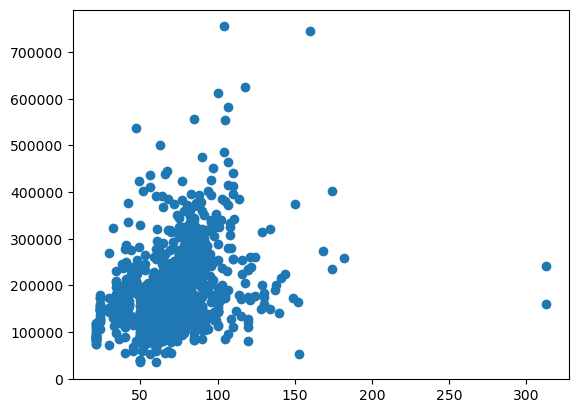

In [16]:
plt.scatter(train['LotFrontage'], train['SalePrice'])

In [17]:
train['LotFrontage'].corr(train['SalePrice'])

0.35179909657067804

We've seen that there is no trends and strong correlation between LotFrontage and SalePrice, so it is possible to get rid of it instead of filling Nans with some values

In [18]:
train[train['GarageType'].isna()][['GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']].isna().sum()

GarageYrBlt     81
GarageFinish    81
GarageQual      81
GarageCond      81
dtype: int64

All missing values of features which describe garage are missing simultaneously, which means abscence of the garage itself and also could be filled with "NA"

In [20]:
garage_cols = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']

In [21]:
train[train['BsmtExposure'].isna()][['BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']].isna().sum()

BsmtFinType2    37
BsmtQual        37
BsmtCond        37
BsmtFinType1    37
dtype: int64

In [22]:
#from ydata_profiling import ProfileReport

In [25]:
#train.profile_report()

In [26]:
data_train_features = train.copy()

In [27]:
data_train_features.drop(['Id', 'Street', 'Alley', 'LandContour', 'Utilities', 'RoofMatl', 'Heating', 'Electrical', 
                         'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'Functional', 'GarageQual', 'GarageCond',
                         'PavedDrive', '3SsnPorch', 'ScreenPorch', 'Fence', 'MiscFeature', 'MiscVal', 'LotFrontage',
                         'Condition2', 'MasVnrArea', '1stFlrSF', '2ndFlrSF', 'GarageYrBlt', 'PoolQC', 'PoolArea',
                         'MoSold', 'YrSold'], axis=1, inplace=True)

In [28]:
data_train_features.columns

Index(['MSSubClass', 'MSZoning', 'LotArea', 'LotShape', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'HeatingQC', 'CentralAir', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'SaleType',
       'SaleCondition', 'SalePrice'],
      dtype='object')

In [29]:
data_train_features.isna().sum().sort_values(ascending=False).head(20)

FireplaceQu     690
GarageFinish     81
GarageType       81
BsmtFinType2     38
BsmtExposure     38
BsmtFinType1     37
BsmtCond         37
BsmtQual         37
MasVnrType        8
MSSubClass        0
HalfBath          0
CentralAir        0
GrLivArea         0
BsmtFullBath      0
FullBath          0
KitchenQual       0
BedroomAbvGr      0
TotalBsmtSF       0
TotRmsAbvGrd      0
Fireplaces        0
dtype: int64

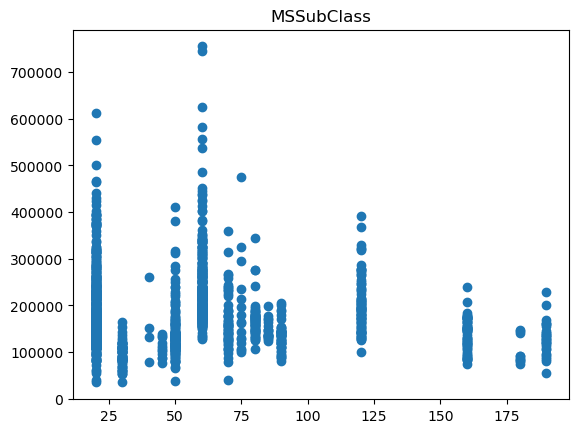

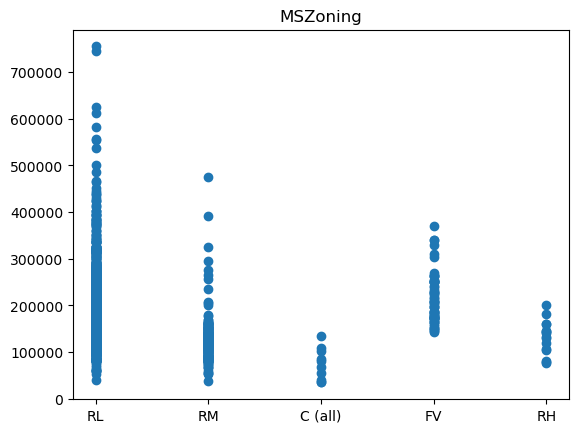

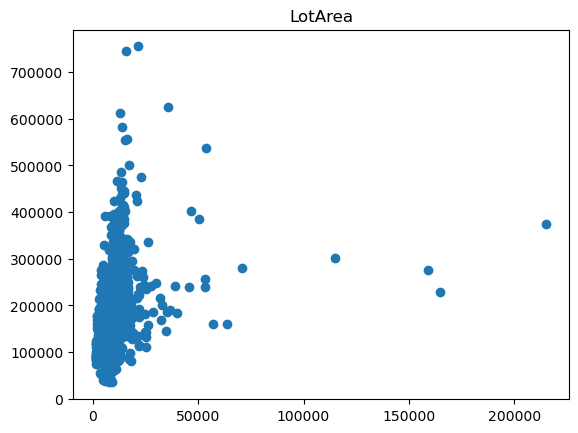

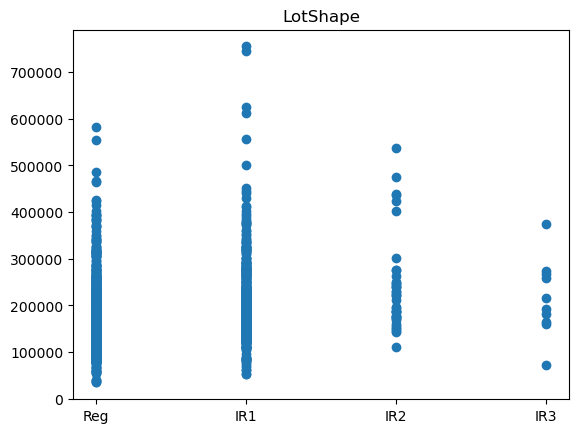

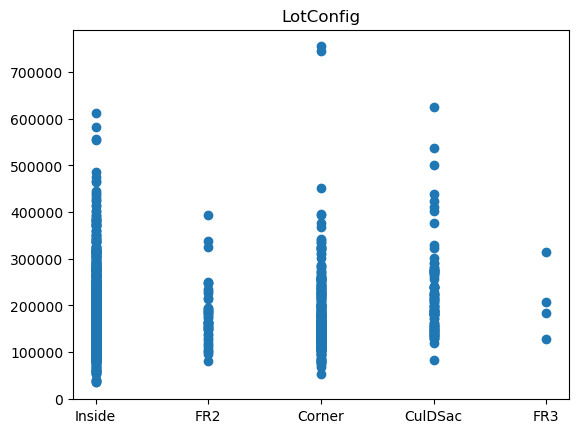

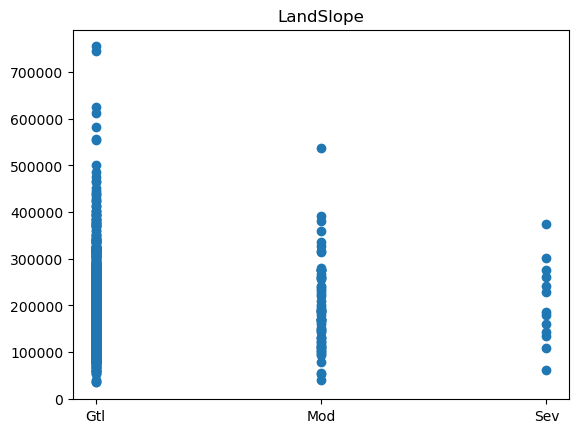

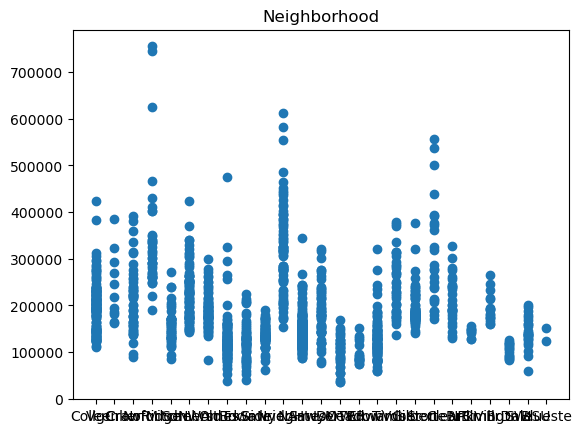

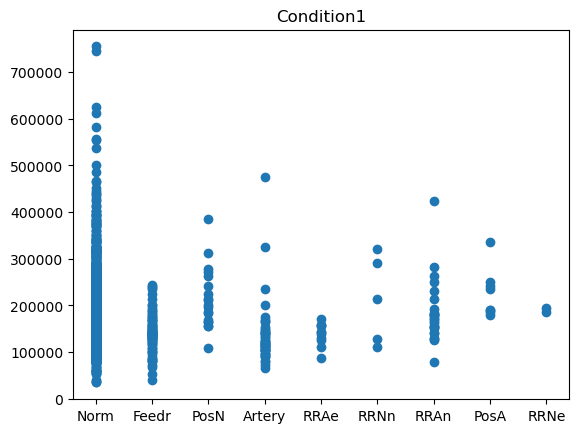

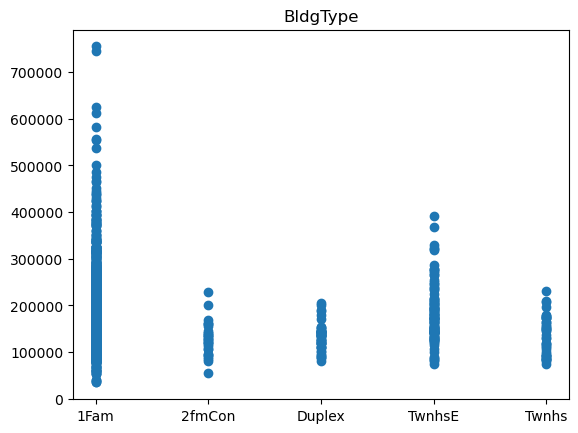

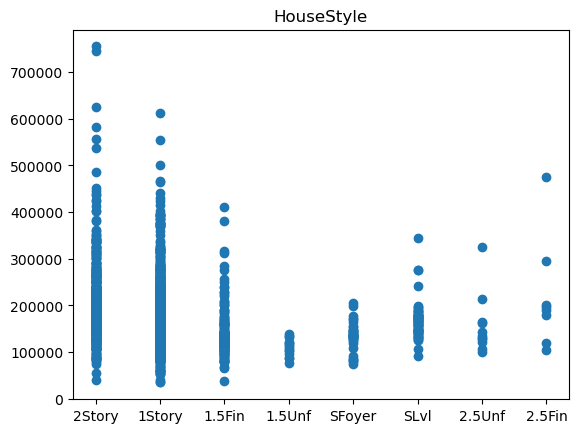

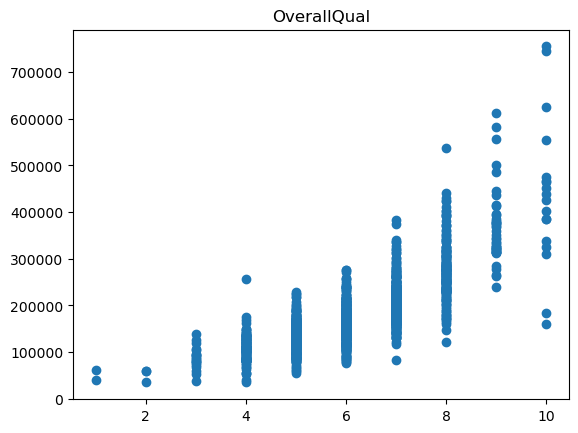

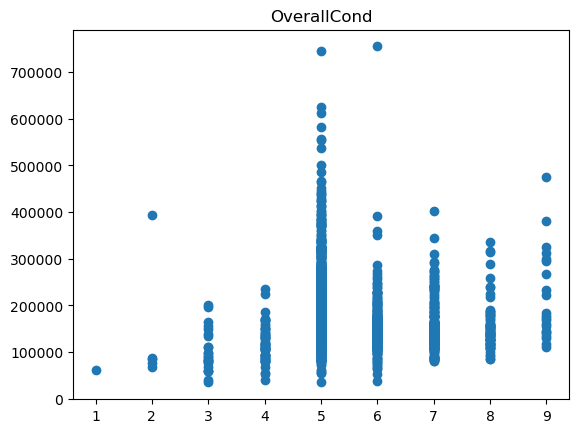

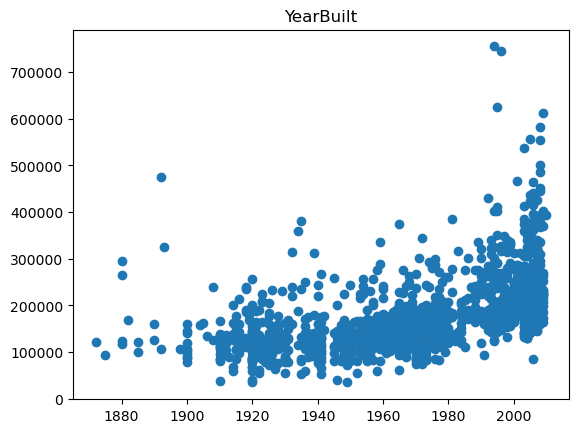

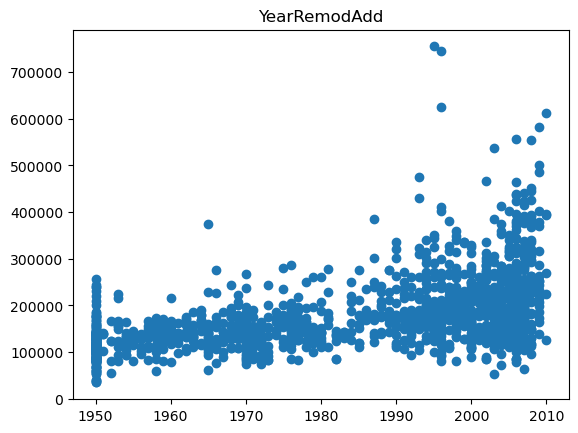

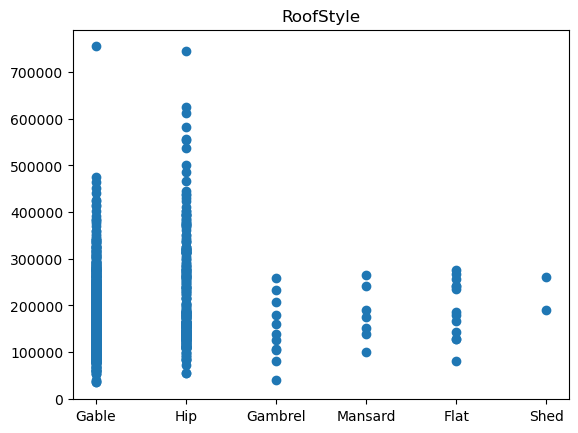

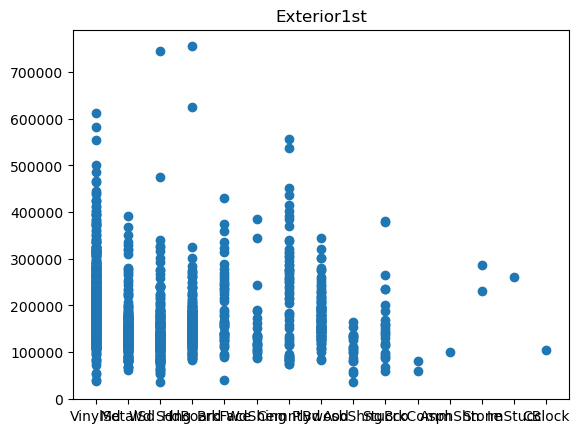

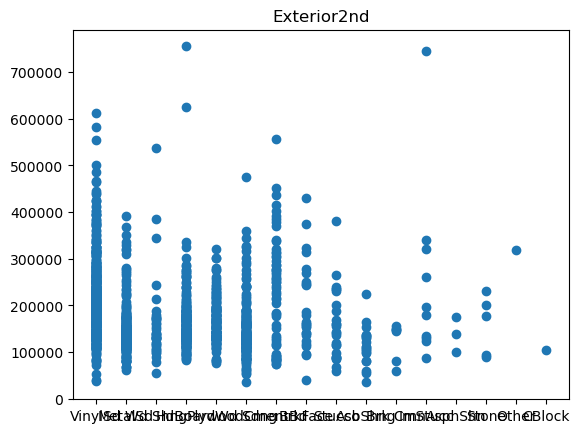

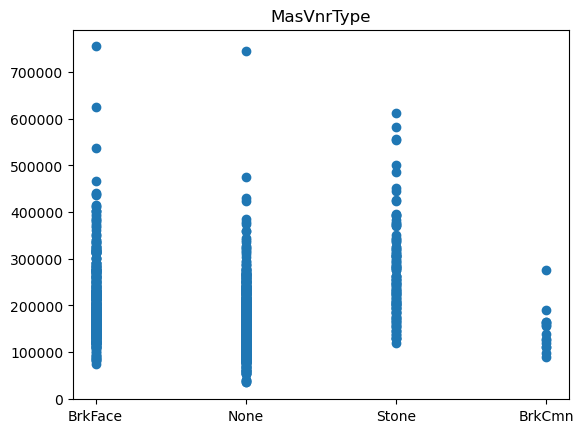

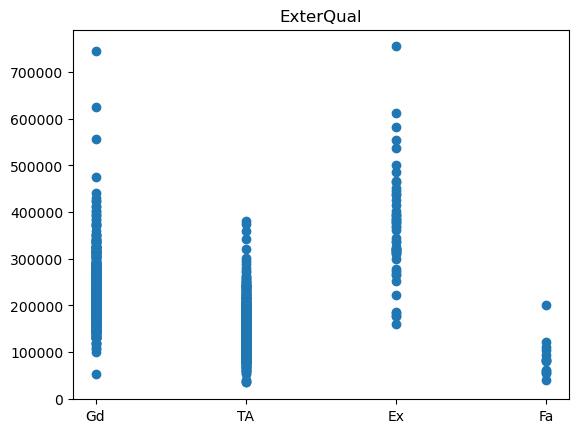

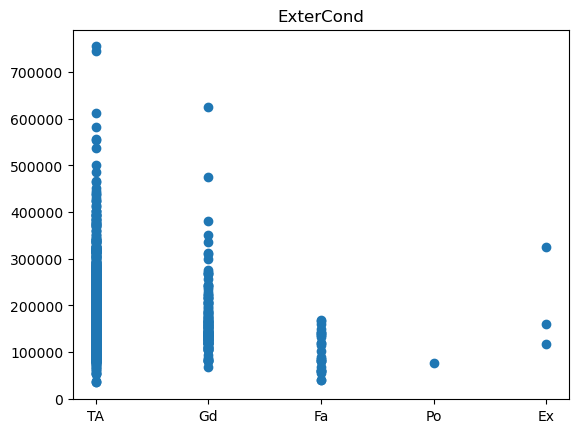

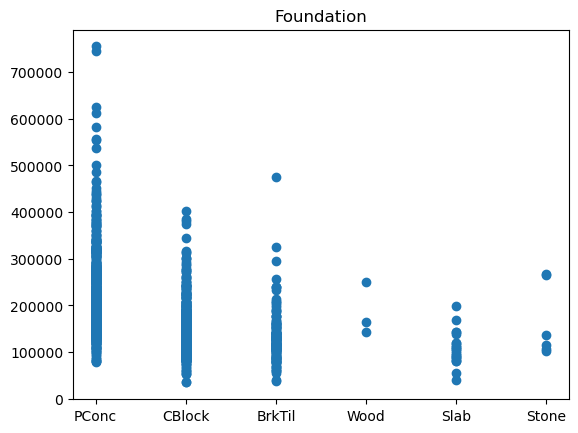

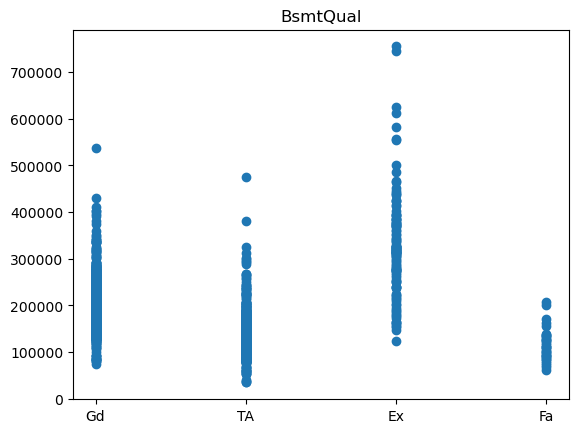

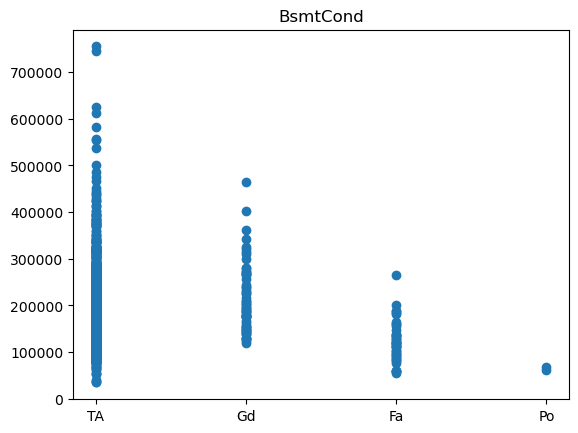

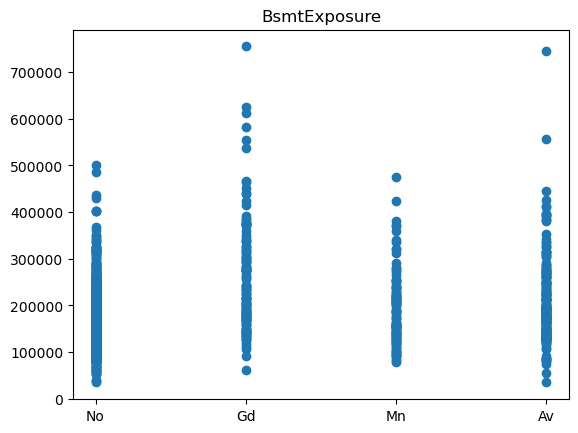

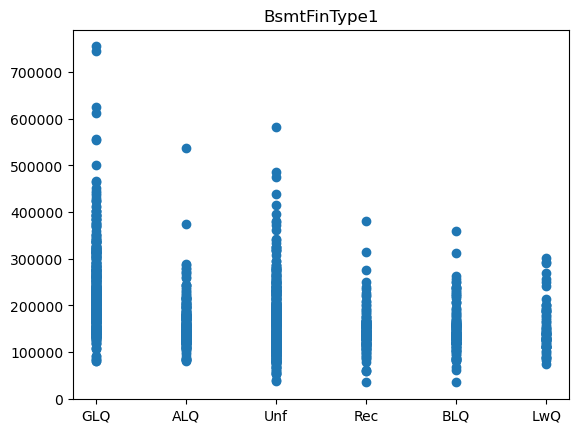

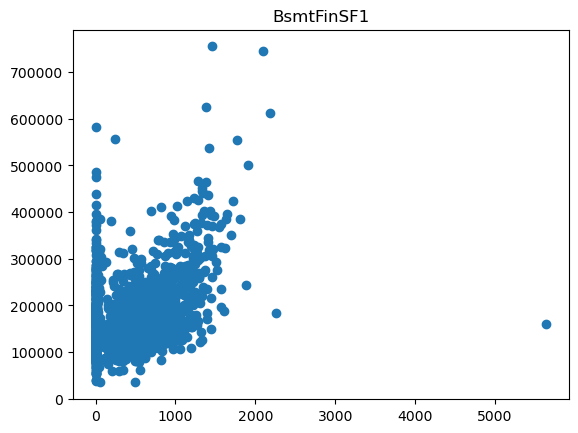

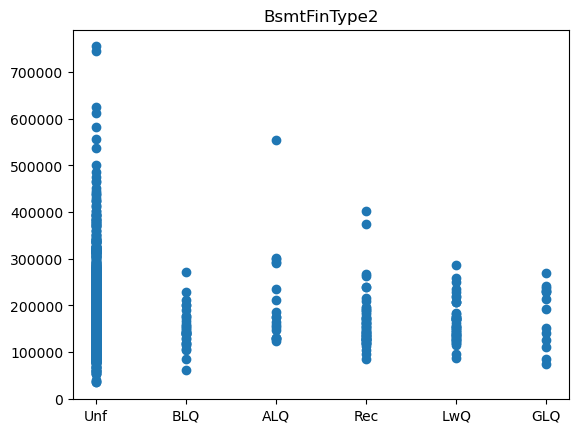

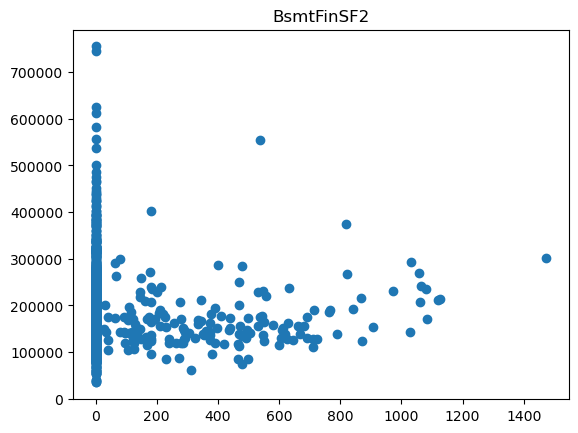

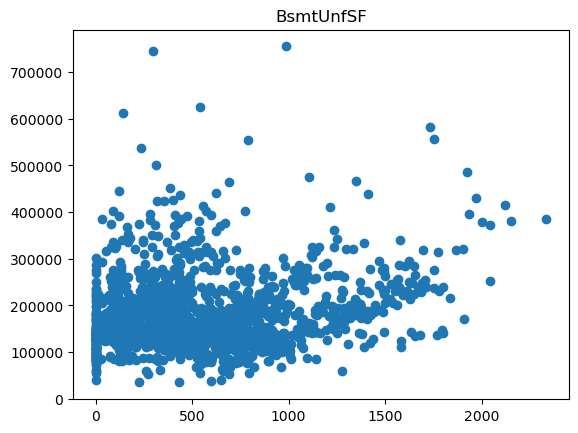

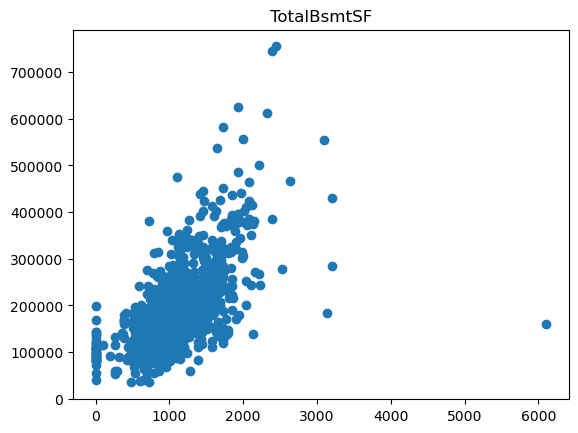

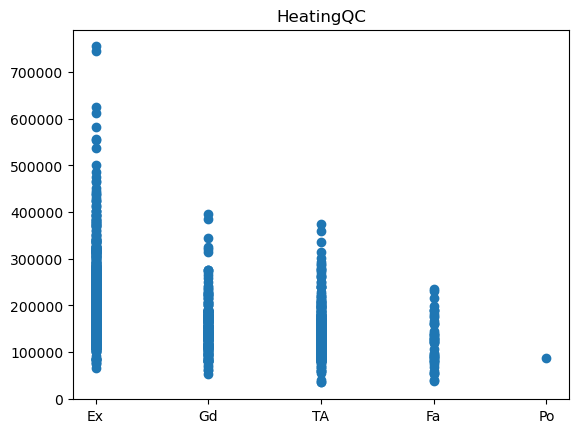

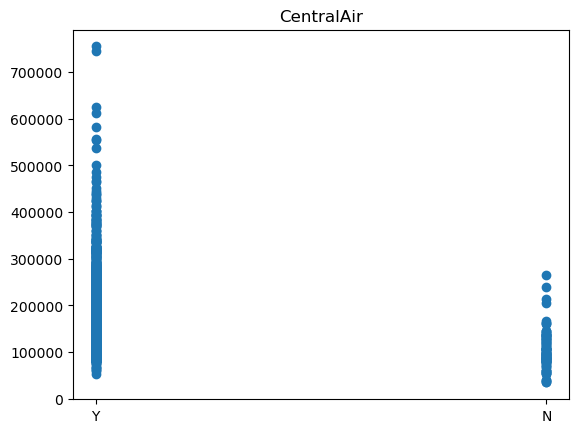

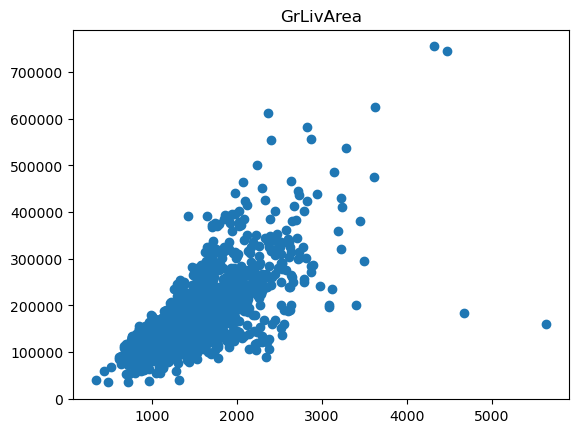

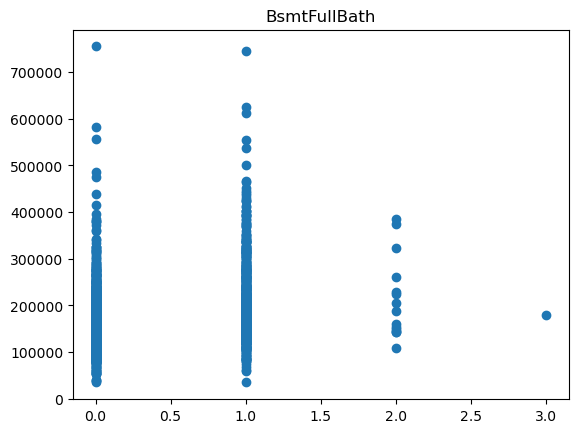

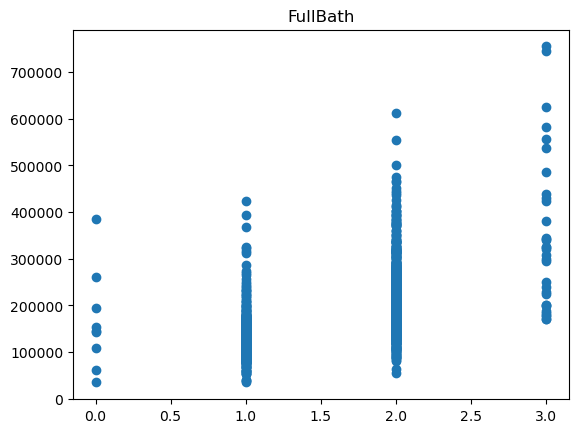

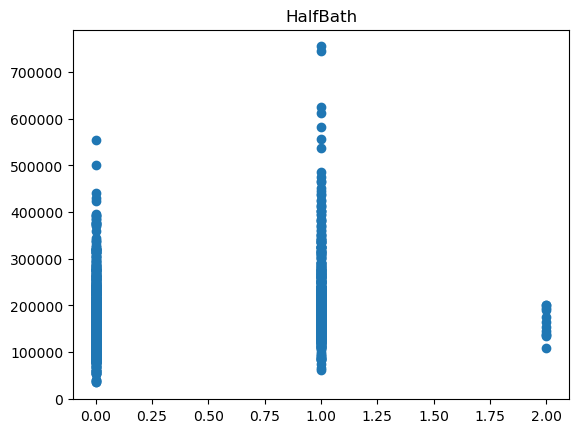

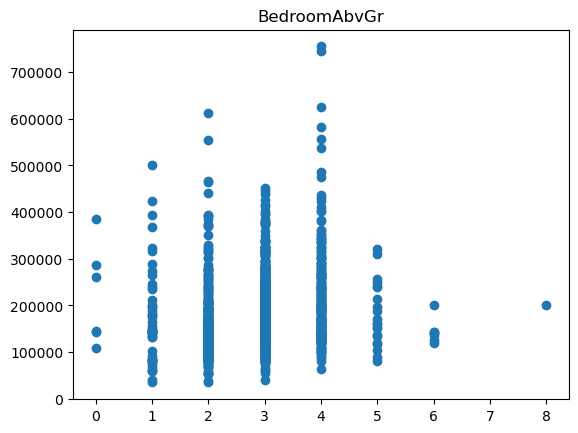

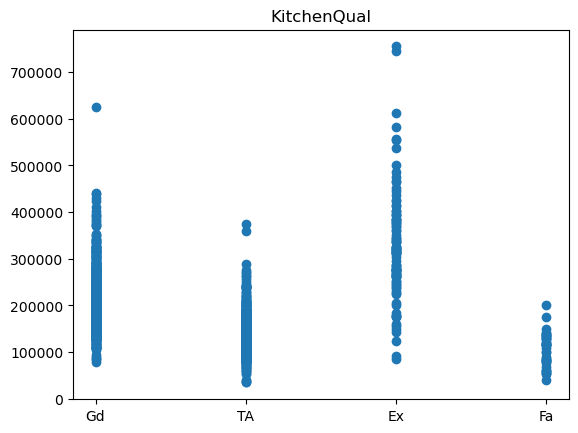

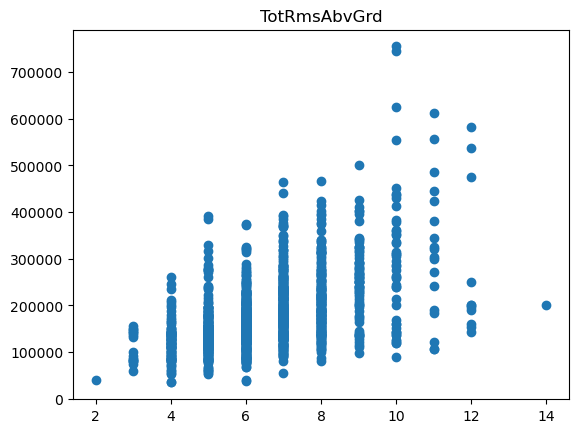

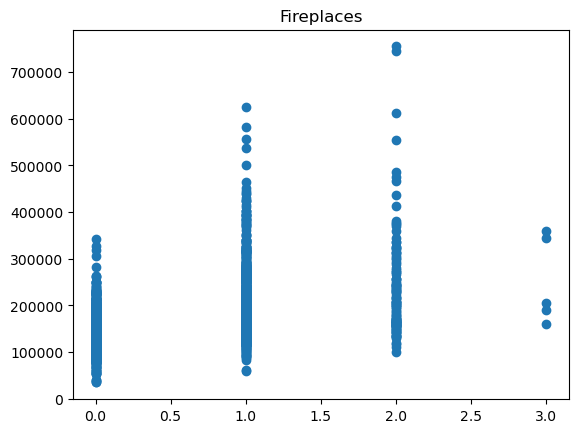

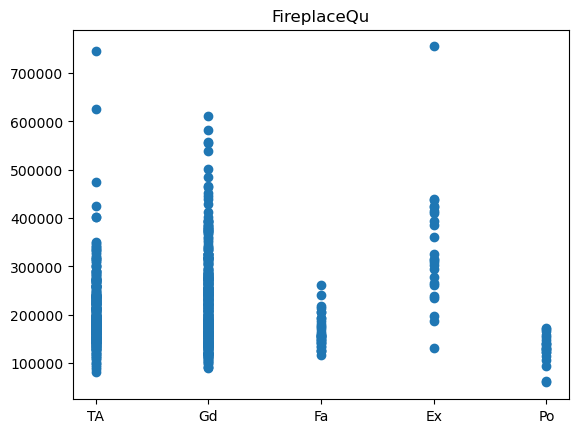

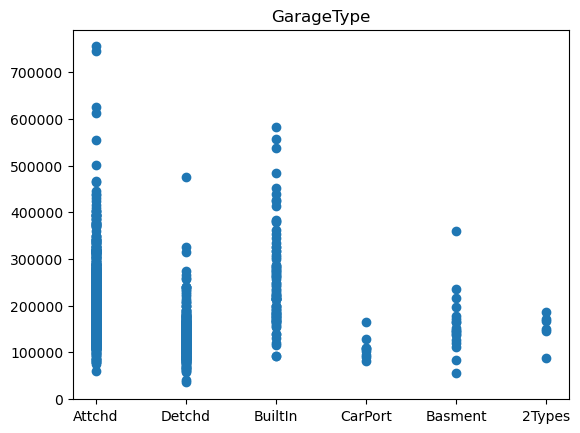

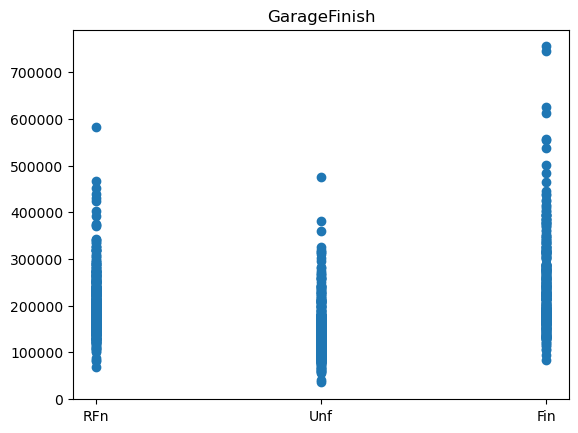

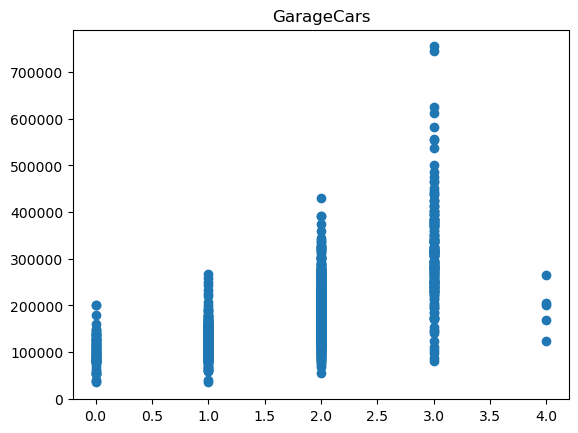

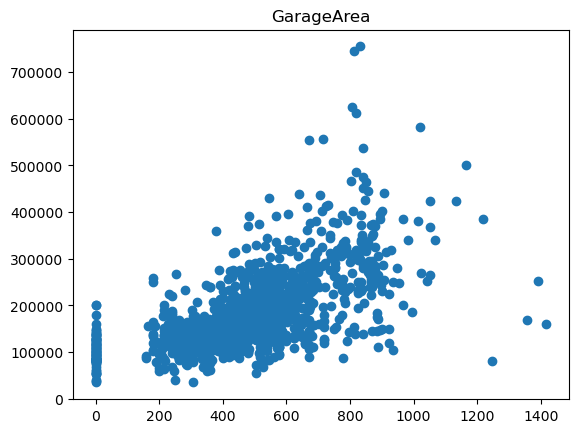

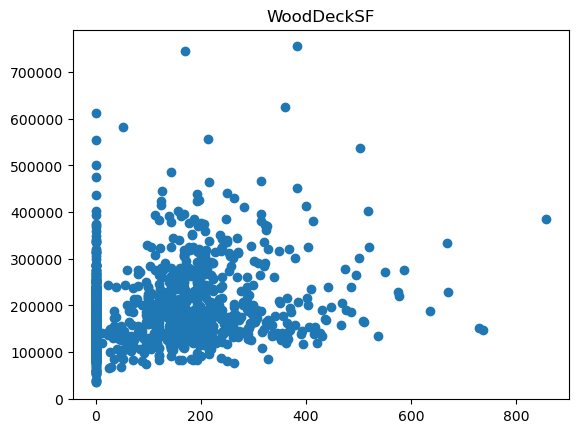

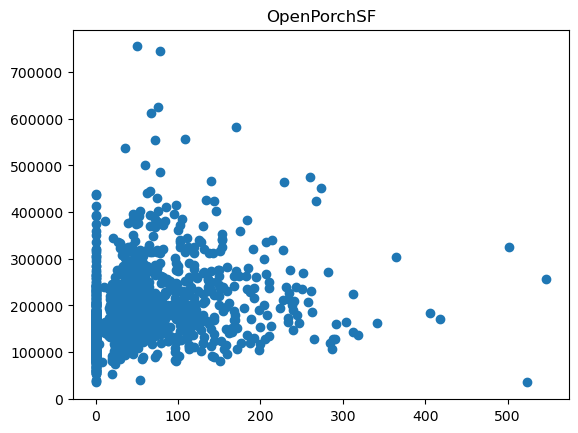

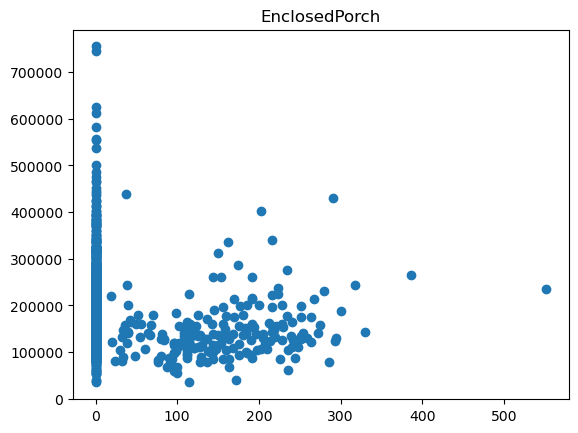

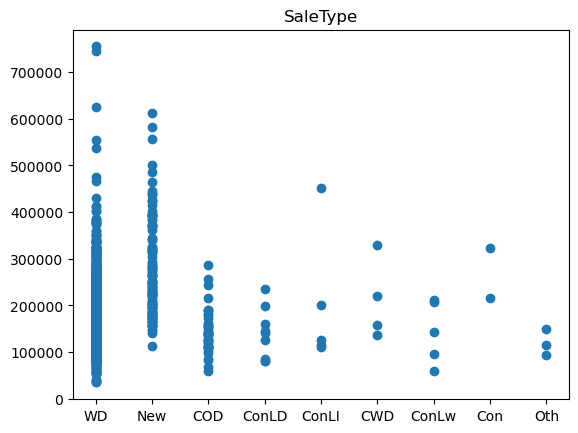

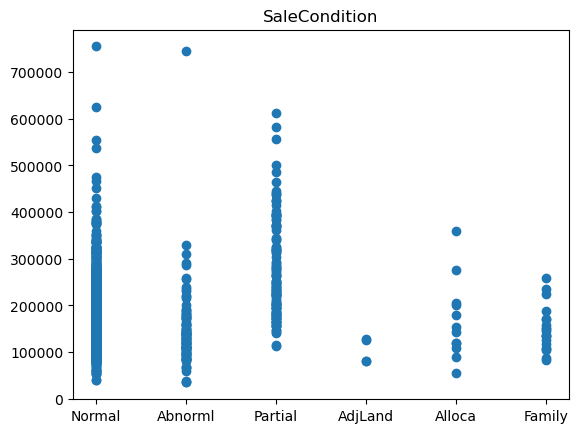

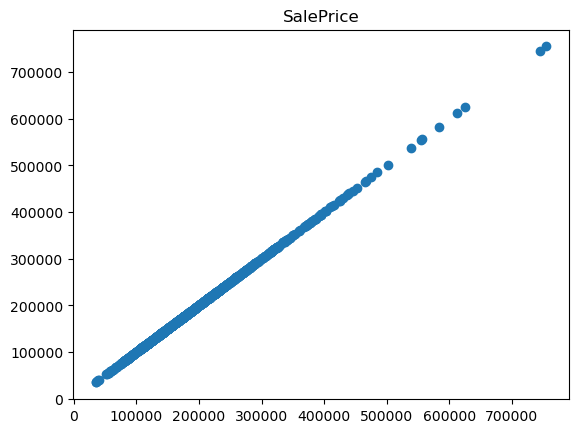

In [30]:
for col in data_train_features.columns:
    plt.scatter(data_train_features[~data_train_features[col].isna()][col], 
                data_train_features[~data_train_features[col].isna()]['SalePrice'], plotnonfinite=True)
    plt.title(col)
    plt.show()

In [31]:
data_train_features.columns

Index(['MSSubClass', 'MSZoning', 'LotArea', 'LotShape', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'HeatingQC', 'CentralAir', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'SaleType',
       'SaleCondition', 'SalePrice'],
      dtype='object')

## Baseline

### Data Preparation

In [39]:
data_train = train.copy()

In [40]:
data_train.drop(['Id', 'LotFrontage'], axis=1, inplace=True)

In [41]:
for col in data_train.columns:
    if data_train[col].dtype == 'object':
        data_train[col].fillna('NA', inplace=True)

In [42]:
data_train['GarageYrBlt'].fillna(data_train['YearBuilt'], inplace=True)

In [43]:
#data_train[data_train['MasVnrArea'].isna()]['MasVnrType']

In [44]:
data_train['MasVnrArea'].fillna(0.0, inplace=True)

In [45]:
def data_preprocessing(data_train):
    X_train, X_test, y_train, y_test = train_test_split(data_train.drop('SalePrice', axis=1), 
                                                        data_train['SalePrice'], 
                                                        test_size=.25, 
                                                        random_state=42)
    cat_features = []
    for i, col in enumerate(data_train.columns):
        if data_train[col].dtype == 'object':
            cat_features.append(col)
    ohe = OneHotEncoder(handle_unknown='infrequent_if_exist')
    ohe.fit(X_train[cat_features])
    cat_features_df = pd.DataFrame(ohe.transform(X_train[cat_features]).toarray(), 
                                   index=X_train.index, 
                                   columns=ohe.get_feature_names_out())
    X_train.drop(cat_features, axis=1, inplace=True)
    X = X_train.join(cat_features_df)
    test_cat_features_df = pd.DataFrame(ohe.transform(X_test[cat_features]).toarray(), 
                                        index=X_test.index, 
                                        columns=ohe.get_feature_names_out())
    X_test.drop(cat_features, axis=1, inplace=True)
    X_t = X_test.join(test_cat_features_df)
    return X, X_t, y_train, y_test

In [46]:
X_train, X_test, y_train, y_test = data_preprocessing(data_train)

In [47]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1095, 299), (365, 299), (1095,), (365,))

### Baseline Model DecisionTree

In [48]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [49]:
preds = model.predict(X_test)

In [50]:
np.sqrt(mean_squared_error(preds, y_test))

38122.47710777562

In [51]:
pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)

OverallQual            0.632764
GrLivArea              0.107074
1stFlrSF               0.038428
2ndFlrSF               0.030746
TotalBsmtSF            0.027225
BsmtFinSF1             0.027128
GarageArea             0.011536
YearBuilt              0.009848
OpenPorchSF            0.007842
GarageType_Detchd      0.007826
LotArea                0.007778
MoSold                 0.007518
Functional_Typ         0.004967
YearRemodAdd           0.004940
OverallCond            0.004839
Exterior2nd_MetalSd    0.004726
GarageCars             0.004704
BedroomAbvGr           0.004381
WoodDeckSF             0.004114
KitchenQual_Gd         0.003814
dtype: float64

### RandomForest with 20 most important features

In [52]:
important_cols = list(pd.Series(model.feature_importances_, index=X_train.columns)
                      .sort_values(ascending=False).head(20).index)

In [53]:
rfr = RandomForestRegressor()
rfr.fit(X_train[important_cols], y_train)

RandomForestRegressor()

In [54]:
np.sqrt(mean_squared_error(rfr.predict(X_test[important_cols]), y_test))

26143.920445973057

### SVR

In [55]:
from sklearn.svm import SVR

In [56]:
svr = SVR(kernel='linear', 
          degree=3, 
          gamma='scale', 
          coef0=0.0, 
          tol=0.001, 
          C=1.0, 
          epsilon=0.1, 
          shrinking=True, 
          cache_size=200, 
          verbose=False, 
          max_iter=-1)

In [57]:
X_train, X_test, y_train, y_test = data_preprocessing(data_train)

In [58]:
svr.fit(X_train, y_train)

SVR(kernel='linear')

In [59]:
np.sqrt(mean_squared_error(svr.predict(X_test), y_test))

38216.49357413022

### LinearRegression

In [60]:
from sklearn.linear_model import LinearRegression

In [61]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [62]:
np.sqrt(mean_squared_error(lr.predict(X_test), y_test))

60657.022318884345

### CatBoostRegressor

In [63]:
from catboost import Pool, CatBoostRegressor

In [64]:
from sklearn.model_selection import GridSearchCV

In [65]:
def extract_cat_features(data):
    cat_features = []
    for i, col in enumerate(data.columns):
        if data[col].dtype == 'object':
            cat_features.append(col)
    cat_features.append('MSSubClass') #!! is numeric but represents categories
    return cat_features

In [118]:
def prepare_and_split_data(input_data, test_size=0):
    data = input_data.copy()
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col].fillna('NA', inplace=True)
        else:
            data[col].fillna(0, inplace=True)
    X = data.drop('SalePrice', axis=1)
    y = data['SalePrice']
    if test_size > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        return X_train, X_test, y_train, y_test
    else:
        return X, y

In [67]:
cat_features = extract_cat_features(data_train_features)

In [68]:
X_train, X_test, y_train, y_test = prepare_and_split_data(data_train_features, test_size=.25)

In [71]:
# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_features)

test_pool = Pool(X_test, 
                 cat_features=cat_features) 

eval_pool = Pool(X_test, 
                 y_test, 
                 cat_features=cat_features)

# specify the training parameters 
model = CatBoostRegressor(iterations=1000, 
                          depth=6, 
                          learning_rate=0.1, 
                          loss_function='RMSE',
                          l2_leaf_reg=4,
                          one_hot_max_size=20,
                          #od_type = "Iter",
                          #od_wait = 100,
                          random_state=42,
                          verbose=50
                          )
#train the model
model.fit(train_pool, eval_set=eval_pool, early_stopping_rounds=20)
# make the prediction using the resulting model
preds = model.predict(test_pool)

0:	learn: 73263.6165966	test: 79072.9299699	best: 79072.9299699 (0)	total: 64.7ms	remaining: 1m 4s
50:	learn: 20674.1831998	test: 28699.4549951	best: 28699.4549951 (50)	total: 158ms	remaining: 2.94s
100:	learn: 15768.9832246	test: 26066.3058997	best: 26066.3058997 (100)	total: 230ms	remaining: 2.05s
150:	learn: 13445.3749391	test: 25676.7468723	best: 25676.7468723 (150)	total: 304ms	remaining: 1.71s
200:	learn: 11440.3783931	test: 25490.1087647	best: 25490.1087647 (200)	total: 374ms	remaining: 1.49s
250:	learn: 10031.7123591	test: 25343.8795755	best: 25343.8795755 (250)	total: 443ms	remaining: 1.32s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 25342.18446
bestIteration = 251

Shrink model to first 252 iterations.


In [72]:
np.sqrt(mean_squared_error(preds, y_test))

25342.18446121626

### Important Features

In [77]:
best_features = list(model.get_feature_importance(prettified=True).head(10)['Feature Id'])

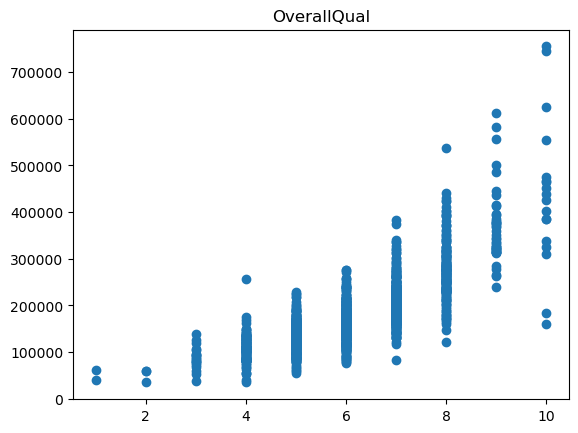

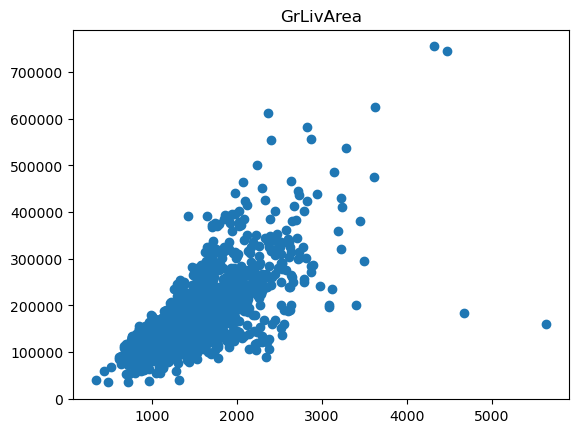

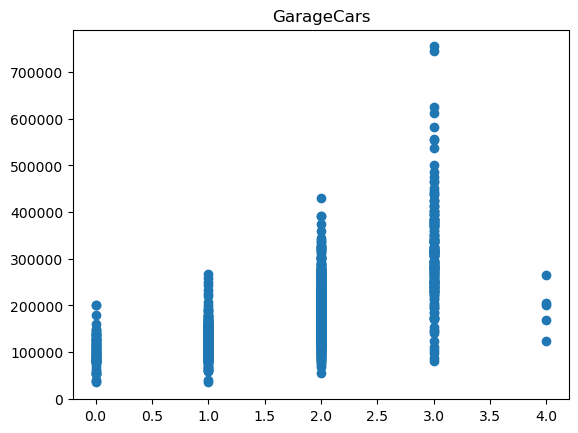

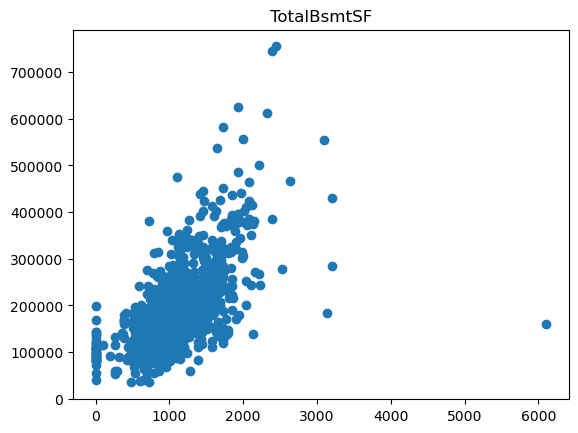

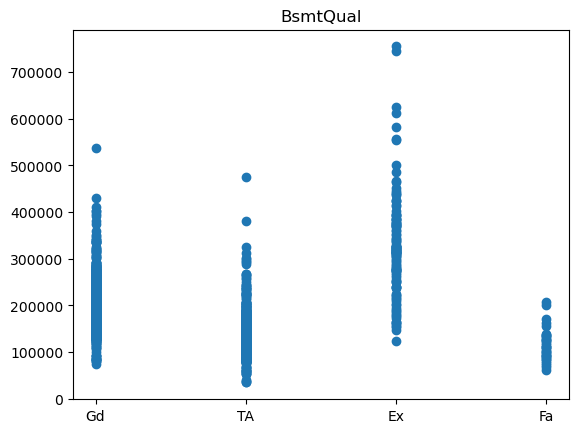

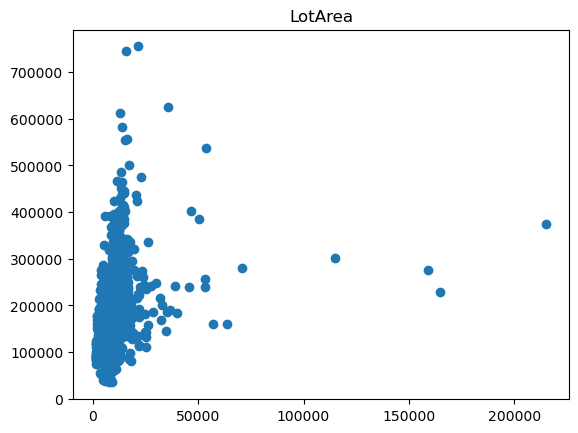

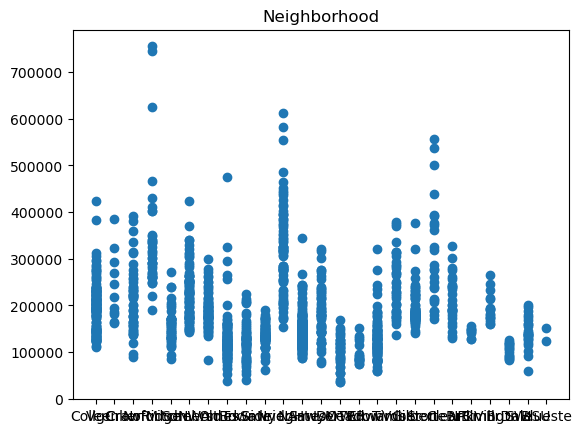

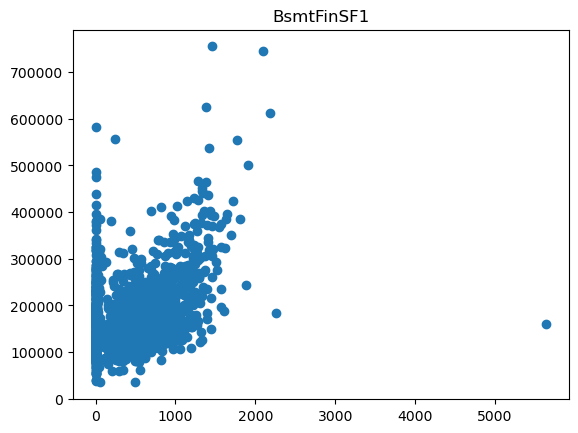

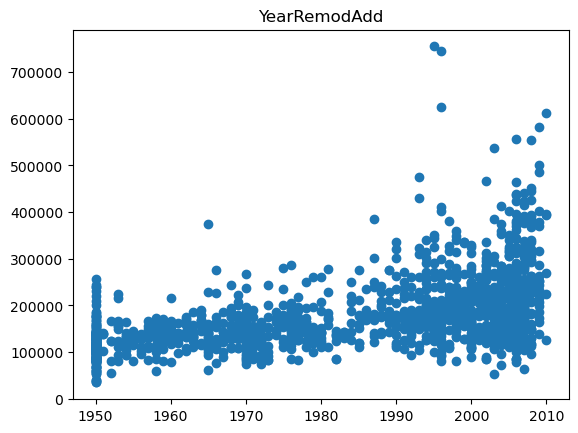

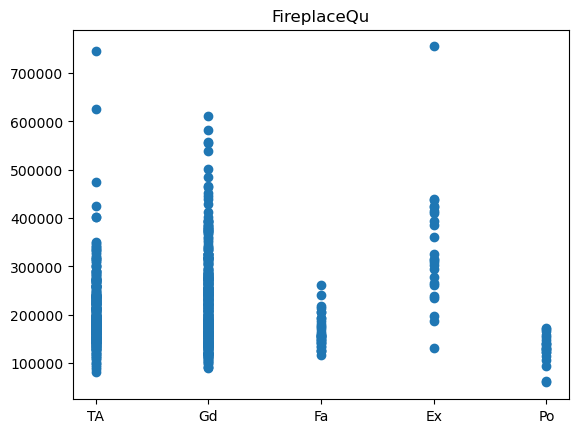

In [163]:
for col in data_train[best_features]:
    plt.scatter(data_train_features[~data_train_features[col].isna()][col], 
                data_train_features[~data_train_features[col].isna()]['SalePrice'], plotnonfinite=True)
    plt.title(col)
    plt.show()

Get rid of outliers

In [81]:
data_train_best = data_train[best_features]

In [83]:
data_train_best = data_train_best[data_train_best['GrLivArea'] <= 4000]

In [84]:
data_train_best = data_train_best[data_train_best['TotalBsmtSF'] <= 4000]

In [ ]:
data_train_best = data_train_best[data_train_best['TotalBsmtSF'] <= 4000]

In [85]:
data_train_best = data_train_best[data_train_best['LotArea'] <= 100000]

In [86]:
data_train_best = data_train_best[data_train_best['BsmtFinSF1'] <= 4000]

In [92]:
data_train_best = data_train_best.join(train['SalePrice'])

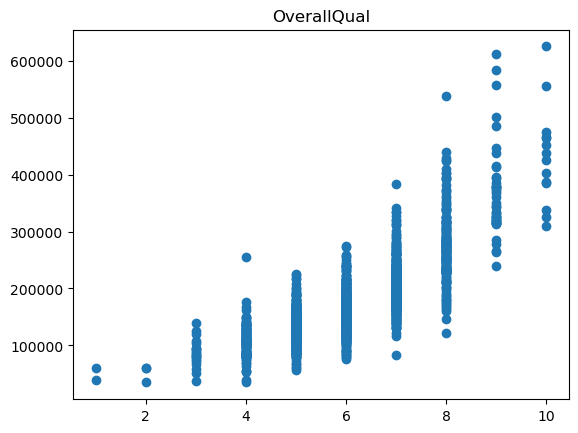

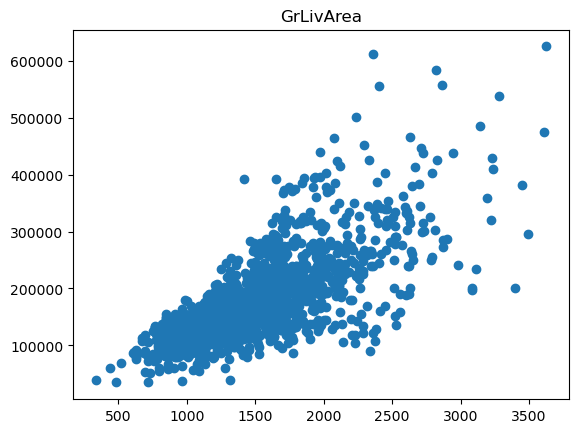

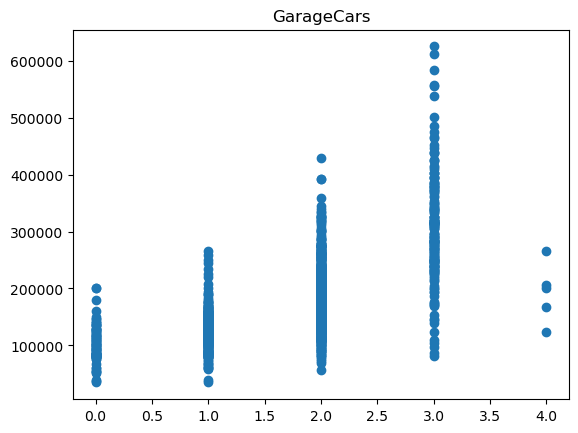

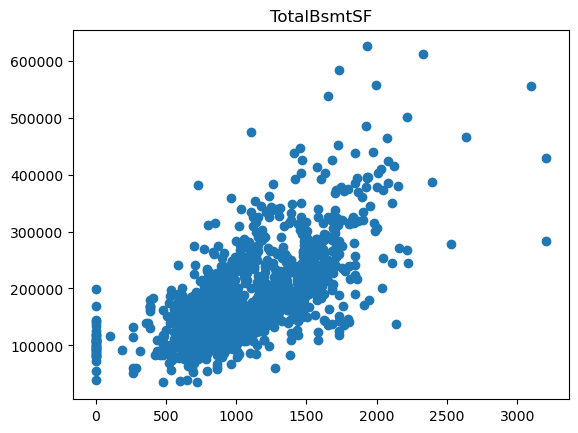

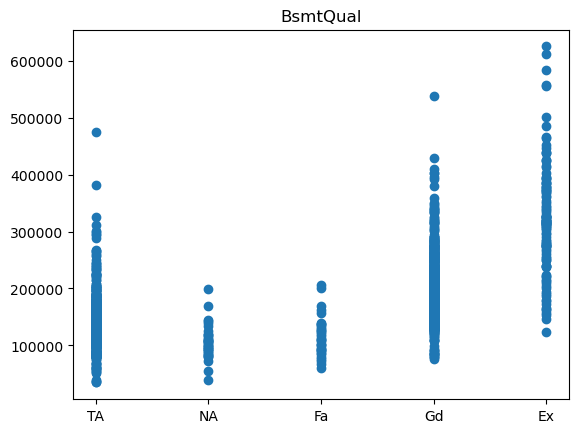

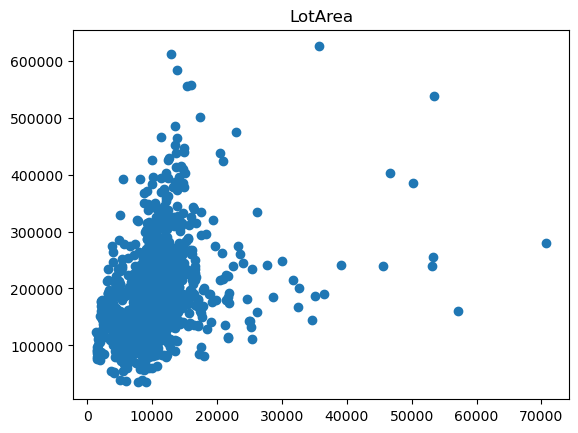

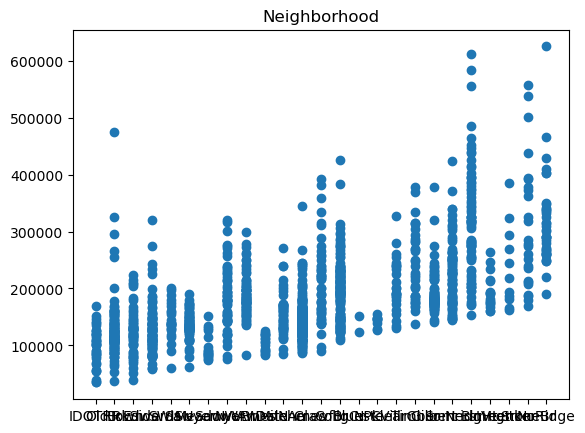

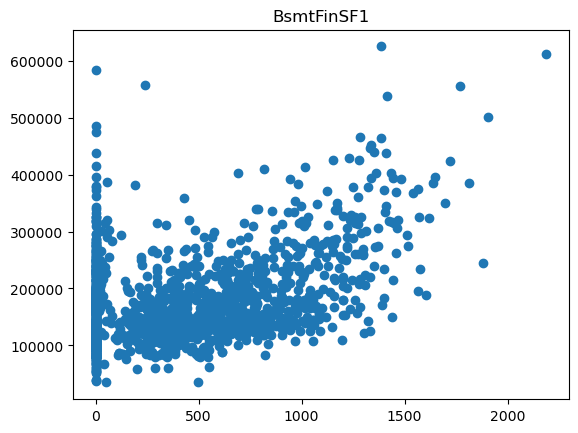

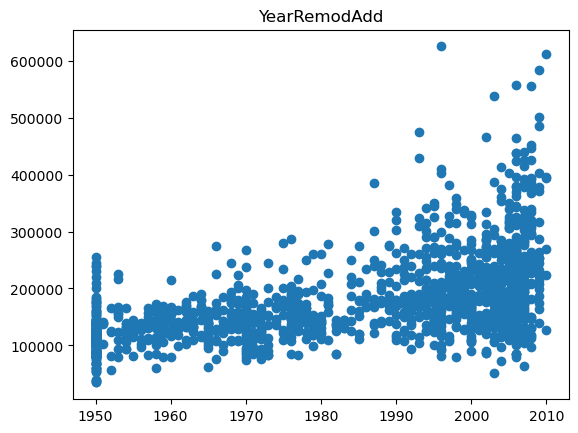

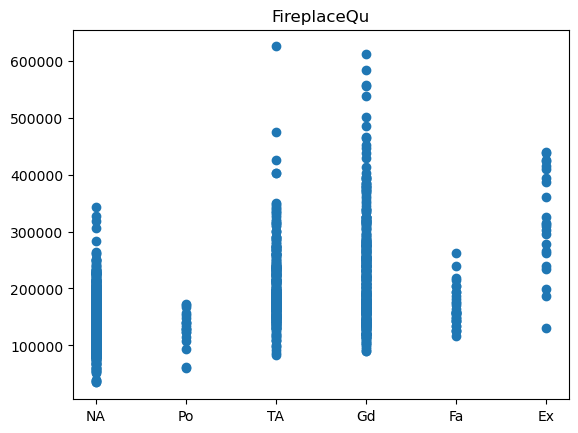

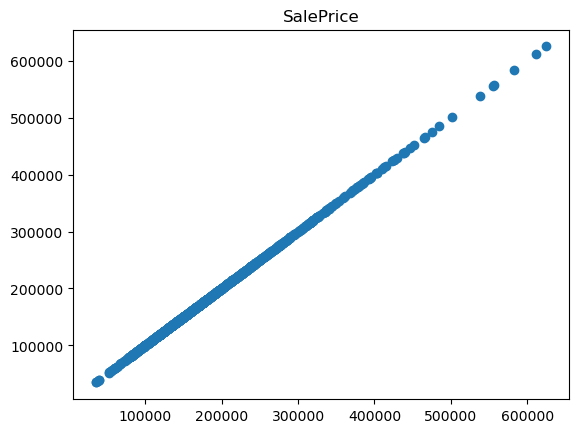

In [165]:
for col in data_train_best.columns:
    plt.scatter(data_train_best[~data_train_best[col].isna()].sort_values(by='SalePrice')[col], 
                data_train_best[~data_train_best[col].isna()].sort_values(by='SalePrice')['SalePrice'], plotnonfinite=True)
    plt.title(col)
    plt.show()

In [94]:
best_cat_features = []
for feature in cat_features:
    if feature in best_features:
        best_cat_features.append(feature)

In [95]:
X_train, X_test, y_train, y_test = prepare_and_split_data(data_train_best)

In [145]:
# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=best_cat_features)

test_pool = Pool(X_test, 
                 cat_features=best_cat_features) 

eval_pool = Pool(X_test, 
                 y_test, 
                 cat_features=best_cat_features)

# specify the training parameters 
model = CatBoostRegressor(iterations=1000, 
                          depth=6, 
                          learning_rate=0.1, 
                          loss_function='RMSE',
                          l2_leaf_reg=4,
                          #one_hot_max_size=20,
                          random_state=42,
                          verbose=50
                          )
#train the model
model.fit(train_pool, eval_set=eval_pool, early_stopping_rounds=30)
# make the prediction using the resulting model
preds = model.predict(test_pool)

0:	learn: 70654.3947939	test: 74453.6634700	best: 74453.6634700 (0)	total: 4.13ms	remaining: 4.13s
50:	learn: 21969.3728513	test: 25775.0615102	best: 25775.0615102 (50)	total: 80.7ms	remaining: 1.5s
100:	learn: 18785.9461761	test: 23908.6505726	best: 23908.6505726 (100)	total: 152ms	remaining: 1.35s
150:	learn: 16273.6567053	test: 23341.0400879	best: 23341.0400879 (150)	total: 222ms	remaining: 1.25s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 23258.75016
bestIteration = 156

Shrink model to first 157 iterations.


In [117]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,OverallQual,25.584476
1,GrLivArea,23.228940
2,BsmtQual,11.210686
3,BsmtFinSF1,8.810637
4,LotArea,6.640380
5,GarageCars,6.528592
6,YearRemodAdd,5.674467
7,TotalBsmtSF,4.972857
8,FireplaceQu,4.350336
9,Neighborhood,2.998629


### Grid Search

Doesn't help much for now. Best parameters so far are above

In [171]:
X_gs, y_gs = prepare_and_split_data(data_train_best)

In [130]:
param_grid = {'depth':range(1,11), 
              'l2_leaf_reg':range(10), 
              'one_hot_max_size':[5, 10, 20, 50, 100]}

model_gs = CatBoostRegressor(cat_features=best_cat_features, verbose=0, iterations=1000)
grid_search = GridSearchCV(model_gs, param_grid, verbose=3, scoring='neg_root_mean_squared_error')

In [131]:
grid_search.fit(X_gs, y_gs)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 1/5] END depth=1, l2_leaf_reg=0, one_hot_max_size=5;, score=-26188.891 total time=   0.3s
[CV 2/5] END depth=1, l2_leaf_reg=0, one_hot_max_size=5;, score=-23820.110 total time=   0.3s
[CV 3/5] END depth=1, l2_leaf_reg=0, one_hot_max_size=5;, score=-27435.436 total time=   0.3s
[CV 4/5] END depth=1, l2_leaf_reg=0, one_hot_max_size=5;, score=-24620.151 total time=   0.3s
[CV 5/5] END depth=1, l2_leaf_reg=0, one_hot_max_size=5;, score=-26824.843 total time=   0.3s
[CV 1/5] END depth=1, l2_leaf_reg=0, one_hot_max_size=10;, score=-25947.256 total time=   0.3s
[CV 2/5] END depth=1, l2_leaf_reg=0, one_hot_max_size=10;, score=-23896.408 total time=   0.3s
[CV 3/5] END depth=1, l2_leaf_reg=0, one_hot_max_size=10;, score=-27486.058 total time=   0.3s
[CV 4/5] END depth=1, l2_leaf_reg=0, one_hot_max_size=10;, score=-24165.202 total time=   0.3s
[CV 5/5] END depth=1, l2_leaf_reg=0, one_hot_max_size=10;, score=-26651.891 total time

[CV 2/5] END depth=1, l2_leaf_reg=3, one_hot_max_size=20;, score=-23725.182 total time=   0.3s
[CV 3/5] END depth=1, l2_leaf_reg=3, one_hot_max_size=20;, score=-27577.763 total time=   0.3s
[CV 4/5] END depth=1, l2_leaf_reg=3, one_hot_max_size=20;, score=-24388.081 total time=   0.3s
[CV 5/5] END depth=1, l2_leaf_reg=3, one_hot_max_size=20;, score=-26661.118 total time=   0.3s
[CV 1/5] END depth=1, l2_leaf_reg=3, one_hot_max_size=50;, score=-26751.018 total time=   0.2s
[CV 2/5] END depth=1, l2_leaf_reg=3, one_hot_max_size=50;, score=-24440.131 total time=   0.2s
[CV 3/5] END depth=1, l2_leaf_reg=3, one_hot_max_size=50;, score=-27657.008 total time=   0.2s
[CV 4/5] END depth=1, l2_leaf_reg=3, one_hot_max_size=50;, score=-24524.148 total time=   0.2s
[CV 5/5] END depth=1, l2_leaf_reg=3, one_hot_max_size=50;, score=-26335.180 total time=   0.2s
[CV 1/5] END depth=1, l2_leaf_reg=3, one_hot_max_size=100;, score=-26751.018 total time=   0.2s
[CV 2/5] END depth=1, l2_leaf_reg=3, one_hot_max_

[CV 5/5] END depth=1, l2_leaf_reg=6, one_hot_max_size=100;, score=-26533.748 total time=   0.2s
[CV 1/5] END depth=1, l2_leaf_reg=7, one_hot_max_size=5;, score=-26141.291 total time=   0.3s
[CV 2/5] END depth=1, l2_leaf_reg=7, one_hot_max_size=5;, score=-23980.041 total time=   0.3s
[CV 3/5] END depth=1, l2_leaf_reg=7, one_hot_max_size=5;, score=-27708.755 total time=   0.3s
[CV 4/5] END depth=1, l2_leaf_reg=7, one_hot_max_size=5;, score=-24749.777 total time=   0.3s
[CV 5/5] END depth=1, l2_leaf_reg=7, one_hot_max_size=5;, score=-26970.196 total time=   0.3s
[CV 1/5] END depth=1, l2_leaf_reg=7, one_hot_max_size=10;, score=-26020.169 total time=   0.3s
[CV 2/5] END depth=1, l2_leaf_reg=7, one_hot_max_size=10;, score=-23852.197 total time=   0.3s
[CV 3/5] END depth=1, l2_leaf_reg=7, one_hot_max_size=10;, score=-27540.683 total time=   0.3s
[CV 4/5] END depth=1, l2_leaf_reg=7, one_hot_max_size=10;, score=-24697.150 total time=   0.3s
[CV 5/5] END depth=1, l2_leaf_reg=7, one_hot_max_size=

[CV 2/5] END depth=2, l2_leaf_reg=0, one_hot_max_size=20;, score=-23015.661 total time=   0.4s
[CV 3/5] END depth=2, l2_leaf_reg=0, one_hot_max_size=20;, score=-24533.285 total time=   0.4s
[CV 4/5] END depth=2, l2_leaf_reg=0, one_hot_max_size=20;, score=-20752.611 total time=   0.4s
[CV 5/5] END depth=2, l2_leaf_reg=0, one_hot_max_size=20;, score=-24612.563 total time=   0.4s
[CV 1/5] END depth=2, l2_leaf_reg=0, one_hot_max_size=50;, score=-25720.860 total time=   0.3s
[CV 2/5] END depth=2, l2_leaf_reg=0, one_hot_max_size=50;, score=-23203.941 total time=   0.3s
[CV 3/5] END depth=2, l2_leaf_reg=0, one_hot_max_size=50;, score=-25101.724 total time=   0.3s
[CV 4/5] END depth=2, l2_leaf_reg=0, one_hot_max_size=50;, score=-22072.820 total time=   0.3s
[CV 5/5] END depth=2, l2_leaf_reg=0, one_hot_max_size=50;, score=-23958.368 total time=   0.3s
[CV 1/5] END depth=2, l2_leaf_reg=0, one_hot_max_size=100;, score=-25720.860 total time=   0.3s
[CV 2/5] END depth=2, l2_leaf_reg=0, one_hot_max_

[CV 4/5] END depth=2, l2_leaf_reg=3, one_hot_max_size=100;, score=-22048.773 total time=   0.3s
[CV 5/5] END depth=2, l2_leaf_reg=3, one_hot_max_size=100;, score=-24323.324 total time=   0.3s
[CV 1/5] END depth=2, l2_leaf_reg=4, one_hot_max_size=5;, score=-23976.353 total time=   0.4s
[CV 2/5] END depth=2, l2_leaf_reg=4, one_hot_max_size=5;, score=-22541.532 total time=   0.4s
[CV 3/5] END depth=2, l2_leaf_reg=4, one_hot_max_size=5;, score=-25747.518 total time=   0.4s
[CV 4/5] END depth=2, l2_leaf_reg=4, one_hot_max_size=5;, score=-20941.712 total time=   0.4s
[CV 5/5] END depth=2, l2_leaf_reg=4, one_hot_max_size=5;, score=-24728.632 total time=   0.4s
[CV 1/5] END depth=2, l2_leaf_reg=4, one_hot_max_size=10;, score=-23905.102 total time=   0.4s
[CV 2/5] END depth=2, l2_leaf_reg=4, one_hot_max_size=10;, score=-23153.220 total time=   0.4s
[CV 3/5] END depth=2, l2_leaf_reg=4, one_hot_max_size=10;, score=-25451.193 total time=   0.4s
[CV 4/5] END depth=2, l2_leaf_reg=4, one_hot_max_size

[CV 1/5] END depth=2, l2_leaf_reg=7, one_hot_max_size=20;, score=-24495.838 total time=   0.4s
[CV 2/5] END depth=2, l2_leaf_reg=7, one_hot_max_size=20;, score=-23092.740 total time=   0.4s
[CV 3/5] END depth=2, l2_leaf_reg=7, one_hot_max_size=20;, score=-25735.196 total time=   0.4s
[CV 4/5] END depth=2, l2_leaf_reg=7, one_hot_max_size=20;, score=-21225.949 total time=   0.4s
[CV 5/5] END depth=2, l2_leaf_reg=7, one_hot_max_size=20;, score=-25144.164 total time=   0.4s
[CV 1/5] END depth=2, l2_leaf_reg=7, one_hot_max_size=50;, score=-25170.634 total time=   0.3s
[CV 2/5] END depth=2, l2_leaf_reg=7, one_hot_max_size=50;, score=-23177.779 total time=   0.3s
[CV 3/5] END depth=2, l2_leaf_reg=7, one_hot_max_size=50;, score=-25886.726 total time=   0.3s
[CV 4/5] END depth=2, l2_leaf_reg=7, one_hot_max_size=50;, score=-22011.976 total time=   0.3s
[CV 5/5] END depth=2, l2_leaf_reg=7, one_hot_max_size=50;, score=-24556.193 total time=   0.3s
[CV 1/5] END depth=2, l2_leaf_reg=7, one_hot_max_s

[CV 3/5] END depth=3, l2_leaf_reg=0, one_hot_max_size=100;, score=-25073.700 total time=   0.3s
[CV 4/5] END depth=3, l2_leaf_reg=0, one_hot_max_size=100;, score=-20943.970 total time=   0.4s
[CV 5/5] END depth=3, l2_leaf_reg=0, one_hot_max_size=100;, score=-24489.739 total time=   0.4s
[CV 1/5] END depth=3, l2_leaf_reg=1, one_hot_max_size=5;, score=-23590.769 total time=   0.6s
[CV 2/5] END depth=3, l2_leaf_reg=1, one_hot_max_size=5;, score=-23262.972 total time=   0.6s
[CV 3/5] END depth=3, l2_leaf_reg=1, one_hot_max_size=5;, score=-24357.534 total time=   0.6s
[CV 4/5] END depth=3, l2_leaf_reg=1, one_hot_max_size=5;, score=-20298.470 total time=   0.6s
[CV 5/5] END depth=3, l2_leaf_reg=1, one_hot_max_size=5;, score=-24516.901 total time=   0.6s
[CV 1/5] END depth=3, l2_leaf_reg=1, one_hot_max_size=10;, score=-23780.742 total time=   0.6s
[CV 2/5] END depth=3, l2_leaf_reg=1, one_hot_max_size=10;, score=-23218.223 total time=   0.6s
[CV 3/5] END depth=3, l2_leaf_reg=1, one_hot_max_siz

[CV 5/5] END depth=3, l2_leaf_reg=4, one_hot_max_size=10;, score=-25055.082 total time=   0.6s
[CV 1/5] END depth=3, l2_leaf_reg=4, one_hot_max_size=20;, score=-22945.031 total time=   0.6s
[CV 2/5] END depth=3, l2_leaf_reg=4, one_hot_max_size=20;, score=-23033.167 total time=   0.5s
[CV 3/5] END depth=3, l2_leaf_reg=4, one_hot_max_size=20;, score=-25220.870 total time=   0.6s
[CV 4/5] END depth=3, l2_leaf_reg=4, one_hot_max_size=20;, score=-20439.833 total time=   0.6s
[CV 5/5] END depth=3, l2_leaf_reg=4, one_hot_max_size=20;, score=-25055.082 total time=   0.6s
[CV 1/5] END depth=3, l2_leaf_reg=4, one_hot_max_size=50;, score=-24368.134 total time=   0.4s
[CV 2/5] END depth=3, l2_leaf_reg=4, one_hot_max_size=50;, score=-23581.686 total time=   0.3s
[CV 3/5] END depth=3, l2_leaf_reg=4, one_hot_max_size=50;, score=-25327.409 total time=   0.4s
[CV 4/5] END depth=3, l2_leaf_reg=4, one_hot_max_size=50;, score=-20767.669 total time=   0.4s
[CV 5/5] END depth=3, l2_leaf_reg=4, one_hot_max_s

[CV 2/5] END depth=3, l2_leaf_reg=7, one_hot_max_size=100;, score=-23558.533 total time=   0.4s
[CV 3/5] END depth=3, l2_leaf_reg=7, one_hot_max_size=100;, score=-25513.779 total time=   0.4s
[CV 4/5] END depth=3, l2_leaf_reg=7, one_hot_max_size=100;, score=-20747.183 total time=   0.4s
[CV 5/5] END depth=3, l2_leaf_reg=7, one_hot_max_size=100;, score=-24299.382 total time=   0.4s
[CV 1/5] END depth=3, l2_leaf_reg=8, one_hot_max_size=5;, score=-23507.945 total time=   0.6s
[CV 2/5] END depth=3, l2_leaf_reg=8, one_hot_max_size=5;, score=-22835.124 total time=   0.6s
[CV 3/5] END depth=3, l2_leaf_reg=8, one_hot_max_size=5;, score=-25227.342 total time=   0.6s
[CV 4/5] END depth=3, l2_leaf_reg=8, one_hot_max_size=5;, score=-20740.340 total time=   0.6s
[CV 5/5] END depth=3, l2_leaf_reg=8, one_hot_max_size=5;, score=-24576.505 total time=   0.6s
[CV 1/5] END depth=3, l2_leaf_reg=8, one_hot_max_size=10;, score=-23295.350 total time=   0.6s
[CV 2/5] END depth=3, l2_leaf_reg=8, one_hot_max_si

[CV 4/5] END depth=4, l2_leaf_reg=1, one_hot_max_size=10;, score=-20654.563 total time=   0.7s
[CV 5/5] END depth=4, l2_leaf_reg=1, one_hot_max_size=10;, score=-25652.540 total time=   0.7s
[CV 1/5] END depth=4, l2_leaf_reg=1, one_hot_max_size=20;, score=-22872.518 total time=   0.7s
[CV 2/5] END depth=4, l2_leaf_reg=1, one_hot_max_size=20;, score=-24229.508 total time=   0.7s
[CV 3/5] END depth=4, l2_leaf_reg=1, one_hot_max_size=20;, score=-25216.591 total time=   0.7s
[CV 4/5] END depth=4, l2_leaf_reg=1, one_hot_max_size=20;, score=-20654.563 total time=   0.7s
[CV 5/5] END depth=4, l2_leaf_reg=1, one_hot_max_size=20;, score=-25652.540 total time=   0.7s
[CV 1/5] END depth=4, l2_leaf_reg=1, one_hot_max_size=50;, score=-23813.283 total time=   0.5s
[CV 2/5] END depth=4, l2_leaf_reg=1, one_hot_max_size=50;, score=-22433.827 total time=   0.5s
[CV 3/5] END depth=4, l2_leaf_reg=1, one_hot_max_size=50;, score=-25027.913 total time=   0.5s
[CV 4/5] END depth=4, l2_leaf_reg=1, one_hot_max_s

[CV 1/5] END depth=4, l2_leaf_reg=4, one_hot_max_size=100;, score=-23538.916 total time=   0.5s
[CV 2/5] END depth=4, l2_leaf_reg=4, one_hot_max_size=100;, score=-23082.888 total time=   0.4s
[CV 3/5] END depth=4, l2_leaf_reg=4, one_hot_max_size=100;, score=-25256.629 total time=   0.4s
[CV 4/5] END depth=4, l2_leaf_reg=4, one_hot_max_size=100;, score=-20599.418 total time=   0.5s
[CV 5/5] END depth=4, l2_leaf_reg=4, one_hot_max_size=100;, score=-24537.962 total time=   0.5s
[CV 1/5] END depth=4, l2_leaf_reg=5, one_hot_max_size=5;, score=-23343.134 total time=   0.8s
[CV 2/5] END depth=4, l2_leaf_reg=5, one_hot_max_size=5;, score=-22911.470 total time=   0.8s
[CV 3/5] END depth=4, l2_leaf_reg=5, one_hot_max_size=5;, score=-25337.073 total time=   0.8s
[CV 4/5] END depth=4, l2_leaf_reg=5, one_hot_max_size=5;, score=-20638.631 total time=   0.8s
[CV 5/5] END depth=4, l2_leaf_reg=5, one_hot_max_size=5;, score=-24947.070 total time=   0.8s
[CV 1/5] END depth=4, l2_leaf_reg=5, one_hot_max_s

[CV 3/5] END depth=4, l2_leaf_reg=8, one_hot_max_size=10;, score=-25687.061 total time=   0.8s
[CV 4/5] END depth=4, l2_leaf_reg=8, one_hot_max_size=10;, score=-20703.951 total time=   0.8s
[CV 5/5] END depth=4, l2_leaf_reg=8, one_hot_max_size=10;, score=-25367.053 total time=   0.7s
[CV 1/5] END depth=4, l2_leaf_reg=8, one_hot_max_size=20;, score=-23370.485 total time=   0.7s
[CV 2/5] END depth=4, l2_leaf_reg=8, one_hot_max_size=20;, score=-23256.037 total time=   0.7s
[CV 3/5] END depth=4, l2_leaf_reg=8, one_hot_max_size=20;, score=-25687.061 total time=   0.7s
[CV 4/5] END depth=4, l2_leaf_reg=8, one_hot_max_size=20;, score=-20703.951 total time=   0.7s
[CV 5/5] END depth=4, l2_leaf_reg=8, one_hot_max_size=20;, score=-25367.053 total time=   0.7s
[CV 1/5] END depth=4, l2_leaf_reg=8, one_hot_max_size=50;, score=-23632.816 total time=   0.4s
[CV 2/5] END depth=4, l2_leaf_reg=8, one_hot_max_size=50;, score=-22521.739 total time=   0.5s
[CV 3/5] END depth=4, l2_leaf_reg=8, one_hot_max_s

[CV 5/5] END depth=5, l2_leaf_reg=1, one_hot_max_size=50;, score=-24568.421 total time=   0.6s
[CV 1/5] END depth=5, l2_leaf_reg=1, one_hot_max_size=100;, score=-23687.620 total time=   0.6s
[CV 2/5] END depth=5, l2_leaf_reg=1, one_hot_max_size=100;, score=-22762.111 total time=   0.6s
[CV 3/5] END depth=5, l2_leaf_reg=1, one_hot_max_size=100;, score=-25481.505 total time=   0.6s
[CV 4/5] END depth=5, l2_leaf_reg=1, one_hot_max_size=100;, score=-20358.473 total time=   0.6s
[CV 5/5] END depth=5, l2_leaf_reg=1, one_hot_max_size=100;, score=-24568.421 total time=   0.6s
[CV 1/5] END depth=5, l2_leaf_reg=2, one_hot_max_size=5;, score=-23197.780 total time=   1.0s
[CV 2/5] END depth=5, l2_leaf_reg=2, one_hot_max_size=5;, score=-22827.957 total time=   1.0s
[CV 3/5] END depth=5, l2_leaf_reg=2, one_hot_max_size=5;, score=-25405.688 total time=   1.0s
[CV 4/5] END depth=5, l2_leaf_reg=2, one_hot_max_size=5;, score=-20113.620 total time=   1.0s
[CV 5/5] END depth=5, l2_leaf_reg=2, one_hot_max_

[CV 2/5] END depth=5, l2_leaf_reg=5, one_hot_max_size=10;, score=-23214.004 total time=   0.9s
[CV 3/5] END depth=5, l2_leaf_reg=5, one_hot_max_size=10;, score=-25941.492 total time=   0.9s
[CV 4/5] END depth=5, l2_leaf_reg=5, one_hot_max_size=10;, score=-20467.787 total time=   0.9s
[CV 5/5] END depth=5, l2_leaf_reg=5, one_hot_max_size=10;, score=-25255.787 total time=   0.9s
[CV 1/5] END depth=5, l2_leaf_reg=5, one_hot_max_size=20;, score=-23189.283 total time=   0.9s
[CV 2/5] END depth=5, l2_leaf_reg=5, one_hot_max_size=20;, score=-23214.004 total time=   0.9s
[CV 3/5] END depth=5, l2_leaf_reg=5, one_hot_max_size=20;, score=-25941.492 total time=   0.9s
[CV 4/5] END depth=5, l2_leaf_reg=5, one_hot_max_size=20;, score=-20467.787 total time=   0.9s
[CV 5/5] END depth=5, l2_leaf_reg=5, one_hot_max_size=20;, score=-25255.787 total time=   0.9s
[CV 1/5] END depth=5, l2_leaf_reg=5, one_hot_max_size=50;, score=-23629.453 total time=   0.6s
[CV 2/5] END depth=5, l2_leaf_reg=5, one_hot_max_s

[CV 4/5] END depth=5, l2_leaf_reg=8, one_hot_max_size=50;, score=-20469.351 total time=   0.6s
[CV 5/5] END depth=5, l2_leaf_reg=8, one_hot_max_size=50;, score=-24275.756 total time=   0.6s
[CV 1/5] END depth=5, l2_leaf_reg=8, one_hot_max_size=100;, score=-23408.501 total time=   0.6s
[CV 2/5] END depth=5, l2_leaf_reg=8, one_hot_max_size=100;, score=-22968.636 total time=   0.6s
[CV 3/5] END depth=5, l2_leaf_reg=8, one_hot_max_size=100;, score=-25822.731 total time=   0.6s
[CV 4/5] END depth=5, l2_leaf_reg=8, one_hot_max_size=100;, score=-20469.351 total time=   0.6s
[CV 5/5] END depth=5, l2_leaf_reg=8, one_hot_max_size=100;, score=-24275.756 total time=   0.7s
[CV 1/5] END depth=5, l2_leaf_reg=9, one_hot_max_size=5;, score=-23248.827 total time=   1.0s
[CV 2/5] END depth=5, l2_leaf_reg=9, one_hot_max_size=5;, score=-22776.589 total time=   1.0s
[CV 3/5] END depth=5, l2_leaf_reg=9, one_hot_max_size=5;, score=-25676.371 total time=   1.0s
[CV 4/5] END depth=5, l2_leaf_reg=9, one_hot_max

[CV 1/5] END depth=6, l2_leaf_reg=2, one_hot_max_size=10;, score=-23247.320 total time=   1.1s
[CV 2/5] END depth=6, l2_leaf_reg=2, one_hot_max_size=10;, score=-23494.768 total time=   1.2s
[CV 3/5] END depth=6, l2_leaf_reg=2, one_hot_max_size=10;, score=-25439.497 total time=   1.2s
[CV 4/5] END depth=6, l2_leaf_reg=2, one_hot_max_size=10;, score=-20296.639 total time=   1.1s
[CV 5/5] END depth=6, l2_leaf_reg=2, one_hot_max_size=10;, score=-25628.184 total time=   1.2s
[CV 1/5] END depth=6, l2_leaf_reg=2, one_hot_max_size=20;, score=-23247.320 total time=   1.1s
[CV 2/5] END depth=6, l2_leaf_reg=2, one_hot_max_size=20;, score=-23494.768 total time=   1.1s
[CV 3/5] END depth=6, l2_leaf_reg=2, one_hot_max_size=20;, score=-25439.497 total time=   1.1s
[CV 4/5] END depth=6, l2_leaf_reg=2, one_hot_max_size=20;, score=-20296.639 total time=   1.1s
[CV 5/5] END depth=6, l2_leaf_reg=2, one_hot_max_size=20;, score=-25628.184 total time=   1.1s
[CV 1/5] END depth=6, l2_leaf_reg=2, one_hot_max_s

[CV 3/5] END depth=6, l2_leaf_reg=5, one_hot_max_size=50;, score=-26197.294 total time=   0.8s
[CV 4/5] END depth=6, l2_leaf_reg=5, one_hot_max_size=50;, score=-20332.090 total time=   0.8s
[CV 5/5] END depth=6, l2_leaf_reg=5, one_hot_max_size=50;, score=-24647.309 total time=   0.8s
[CV 1/5] END depth=6, l2_leaf_reg=5, one_hot_max_size=100;, score=-23837.357 total time=   0.8s
[CV 2/5] END depth=6, l2_leaf_reg=5, one_hot_max_size=100;, score=-22561.291 total time=   0.8s
[CV 3/5] END depth=6, l2_leaf_reg=5, one_hot_max_size=100;, score=-26197.294 total time=   0.8s
[CV 4/5] END depth=6, l2_leaf_reg=5, one_hot_max_size=100;, score=-20332.090 total time=   0.7s
[CV 5/5] END depth=6, l2_leaf_reg=5, one_hot_max_size=100;, score=-24647.309 total time=   0.8s
[CV 1/5] END depth=6, l2_leaf_reg=6, one_hot_max_size=5;, score=-23293.376 total time=   1.3s
[CV 2/5] END depth=6, l2_leaf_reg=6, one_hot_max_size=5;, score=-22594.669 total time=   1.2s
[CV 3/5] END depth=6, l2_leaf_reg=6, one_hot_ma

[CV 5/5] END depth=6, l2_leaf_reg=9, one_hot_max_size=5;, score=-24677.835 total time=   1.3s
[CV 1/5] END depth=6, l2_leaf_reg=9, one_hot_max_size=10;, score=-22917.753 total time=   1.2s
[CV 2/5] END depth=6, l2_leaf_reg=9, one_hot_max_size=10;, score=-22347.663 total time=   1.2s
[CV 3/5] END depth=6, l2_leaf_reg=9, one_hot_max_size=10;, score=-25816.090 total time=   1.1s
[CV 4/5] END depth=6, l2_leaf_reg=9, one_hot_max_size=10;, score=-20343.945 total time=   1.1s
[CV 5/5] END depth=6, l2_leaf_reg=9, one_hot_max_size=10;, score=-24861.460 total time=   1.1s
[CV 1/5] END depth=6, l2_leaf_reg=9, one_hot_max_size=20;, score=-22917.753 total time=   1.1s
[CV 2/5] END depth=6, l2_leaf_reg=9, one_hot_max_size=20;, score=-22347.663 total time=   1.1s
[CV 3/5] END depth=6, l2_leaf_reg=9, one_hot_max_size=20;, score=-25816.090 total time=   1.1s
[CV 4/5] END depth=6, l2_leaf_reg=9, one_hot_max_size=20;, score=-20343.945 total time=   1.1s
[CV 5/5] END depth=6, l2_leaf_reg=9, one_hot_max_si

[CV 2/5] END depth=7, l2_leaf_reg=2, one_hot_max_size=50;, score=-23134.695 total time=   1.0s
[CV 3/5] END depth=7, l2_leaf_reg=2, one_hot_max_size=50;, score=-26273.372 total time=   1.0s
[CV 4/5] END depth=7, l2_leaf_reg=2, one_hot_max_size=50;, score=-20586.492 total time=   1.0s
[CV 5/5] END depth=7, l2_leaf_reg=2, one_hot_max_size=50;, score=-25361.802 total time=   1.0s
[CV 1/5] END depth=7, l2_leaf_reg=2, one_hot_max_size=100;, score=-22975.151 total time=   1.0s
[CV 2/5] END depth=7, l2_leaf_reg=2, one_hot_max_size=100;, score=-23134.695 total time=   1.0s
[CV 3/5] END depth=7, l2_leaf_reg=2, one_hot_max_size=100;, score=-26273.372 total time=   1.0s
[CV 4/5] END depth=7, l2_leaf_reg=2, one_hot_max_size=100;, score=-20586.492 total time=   1.0s
[CV 5/5] END depth=7, l2_leaf_reg=2, one_hot_max_size=100;, score=-25361.802 total time=   1.0s
[CV 1/5] END depth=7, l2_leaf_reg=3, one_hot_max_size=5;, score=-23816.422 total time=   1.6s
[CV 2/5] END depth=7, l2_leaf_reg=3, one_hot_m

[CV 4/5] END depth=7, l2_leaf_reg=6, one_hot_max_size=5;, score=-20462.549 total time=   1.6s
[CV 5/5] END depth=7, l2_leaf_reg=6, one_hot_max_size=5;, score=-24625.358 total time=   1.6s
[CV 1/5] END depth=7, l2_leaf_reg=6, one_hot_max_size=10;, score=-23497.881 total time=   1.5s
[CV 2/5] END depth=7, l2_leaf_reg=6, one_hot_max_size=10;, score=-22388.463 total time=   1.4s
[CV 3/5] END depth=7, l2_leaf_reg=6, one_hot_max_size=10;, score=-26106.571 total time=   1.4s
[CV 4/5] END depth=7, l2_leaf_reg=6, one_hot_max_size=10;, score=-20714.833 total time=   1.4s
[CV 5/5] END depth=7, l2_leaf_reg=6, one_hot_max_size=10;, score=-25073.478 total time=   1.4s
[CV 1/5] END depth=7, l2_leaf_reg=6, one_hot_max_size=20;, score=-23497.881 total time=   1.4s
[CV 2/5] END depth=7, l2_leaf_reg=6, one_hot_max_size=20;, score=-22388.463 total time=   1.4s
[CV 3/5] END depth=7, l2_leaf_reg=6, one_hot_max_size=20;, score=-26106.571 total time=   1.4s
[CV 4/5] END depth=7, l2_leaf_reg=6, one_hot_max_siz

[CV 1/5] END depth=7, l2_leaf_reg=9, one_hot_max_size=50;, score=-22982.605 total time=   1.0s
[CV 2/5] END depth=7, l2_leaf_reg=9, one_hot_max_size=50;, score=-22104.261 total time=   1.0s
[CV 3/5] END depth=7, l2_leaf_reg=9, one_hot_max_size=50;, score=-26218.647 total time=   1.0s
[CV 4/5] END depth=7, l2_leaf_reg=9, one_hot_max_size=50;, score=-20529.388 total time=   1.0s
[CV 5/5] END depth=7, l2_leaf_reg=9, one_hot_max_size=50;, score=-24966.269 total time=   1.0s
[CV 1/5] END depth=7, l2_leaf_reg=9, one_hot_max_size=100;, score=-22982.605 total time=   1.0s
[CV 2/5] END depth=7, l2_leaf_reg=9, one_hot_max_size=100;, score=-22104.261 total time=   1.0s
[CV 3/5] END depth=7, l2_leaf_reg=9, one_hot_max_size=100;, score=-26218.647 total time=   1.0s
[CV 4/5] END depth=7, l2_leaf_reg=9, one_hot_max_size=100;, score=-20529.388 total time=   1.0s
[CV 5/5] END depth=7, l2_leaf_reg=9, one_hot_max_size=100;, score=-24966.269 total time=   1.0s
[CV 1/5] END depth=8, l2_leaf_reg=0, one_hot_

[CV 3/5] END depth=8, l2_leaf_reg=3, one_hot_max_size=5;, score=-26236.210 total time=   2.1s
[CV 4/5] END depth=8, l2_leaf_reg=3, one_hot_max_size=5;, score=-20468.560 total time=   2.1s
[CV 5/5] END depth=8, l2_leaf_reg=3, one_hot_max_size=5;, score=-24554.941 total time=   2.1s
[CV 1/5] END depth=8, l2_leaf_reg=3, one_hot_max_size=10;, score=-23587.931 total time=   1.9s
[CV 2/5] END depth=8, l2_leaf_reg=3, one_hot_max_size=10;, score=-22463.712 total time=   1.9s
[CV 3/5] END depth=8, l2_leaf_reg=3, one_hot_max_size=10;, score=-26562.351 total time=   1.8s
[CV 4/5] END depth=8, l2_leaf_reg=3, one_hot_max_size=10;, score=-20596.954 total time=   1.9s
[CV 5/5] END depth=8, l2_leaf_reg=3, one_hot_max_size=10;, score=-25147.698 total time=   1.8s
[CV 1/5] END depth=8, l2_leaf_reg=3, one_hot_max_size=20;, score=-23587.931 total time=   1.9s
[CV 2/5] END depth=8, l2_leaf_reg=3, one_hot_max_size=20;, score=-22463.712 total time=   1.9s
[CV 3/5] END depth=8, l2_leaf_reg=3, one_hot_max_size

[CV 5/5] END depth=8, l2_leaf_reg=6, one_hot_max_size=20;, score=-25206.015 total time=   2.0s
[CV 1/5] END depth=8, l2_leaf_reg=6, one_hot_max_size=50;, score=-23165.250 total time=   1.3s
[CV 2/5] END depth=8, l2_leaf_reg=6, one_hot_max_size=50;, score=-21899.523 total time=   1.3s
[CV 3/5] END depth=8, l2_leaf_reg=6, one_hot_max_size=50;, score=-26913.205 total time=   1.3s
[CV 4/5] END depth=8, l2_leaf_reg=6, one_hot_max_size=50;, score=-20690.506 total time=   1.3s
[CV 5/5] END depth=8, l2_leaf_reg=6, one_hot_max_size=50;, score=-24839.492 total time=   1.3s
[CV 1/5] END depth=8, l2_leaf_reg=6, one_hot_max_size=100;, score=-23165.250 total time=   1.3s
[CV 2/5] END depth=8, l2_leaf_reg=6, one_hot_max_size=100;, score=-21899.523 total time=   1.3s
[CV 3/5] END depth=8, l2_leaf_reg=6, one_hot_max_size=100;, score=-26913.205 total time=   1.3s
[CV 4/5] END depth=8, l2_leaf_reg=6, one_hot_max_size=100;, score=-20690.506 total time=   1.3s
[CV 5/5] END depth=8, l2_leaf_reg=6, one_hot_m

[CV 2/5] END depth=9, l2_leaf_reg=0, one_hot_max_size=5;, score=-23610.723 total time=   4.0s
[CV 3/5] END depth=9, l2_leaf_reg=0, one_hot_max_size=5;, score=-26675.720 total time=   3.9s
[CV 4/5] END depth=9, l2_leaf_reg=0, one_hot_max_size=5;, score=-21576.679 total time=   3.9s
[CV 5/5] END depth=9, l2_leaf_reg=0, one_hot_max_size=5;, score=-24837.981 total time=   3.9s
[CV 1/5] END depth=9, l2_leaf_reg=0, one_hot_max_size=10;, score=-24044.921 total time=   3.2s
[CV 2/5] END depth=9, l2_leaf_reg=0, one_hot_max_size=10;, score=-23069.296 total time=   3.0s
[CV 3/5] END depth=9, l2_leaf_reg=0, one_hot_max_size=10;, score=-27974.968 total time=   3.0s
[CV 4/5] END depth=9, l2_leaf_reg=0, one_hot_max_size=10;, score=-21252.144 total time=   3.0s
[CV 5/5] END depth=9, l2_leaf_reg=0, one_hot_max_size=10;, score=-26449.304 total time=   3.1s
[CV 1/5] END depth=9, l2_leaf_reg=0, one_hot_max_size=20;, score=-24044.921 total time=   3.2s
[CV 2/5] END depth=9, l2_leaf_reg=0, one_hot_max_size=

[CV 4/5] END depth=9, l2_leaf_reg=3, one_hot_max_size=20;, score=-21370.282 total time=   3.0s
[CV 5/5] END depth=9, l2_leaf_reg=3, one_hot_max_size=20;, score=-25253.847 total time=   3.1s
[CV 1/5] END depth=9, l2_leaf_reg=3, one_hot_max_size=50;, score=-24157.291 total time=   2.1s
[CV 2/5] END depth=9, l2_leaf_reg=3, one_hot_max_size=50;, score=-22935.128 total time=   2.0s
[CV 3/5] END depth=9, l2_leaf_reg=3, one_hot_max_size=50;, score=-26690.296 total time=   2.0s
[CV 4/5] END depth=9, l2_leaf_reg=3, one_hot_max_size=50;, score=-21426.068 total time=   2.0s
[CV 5/5] END depth=9, l2_leaf_reg=3, one_hot_max_size=50;, score=-25411.805 total time=   2.1s
[CV 1/5] END depth=9, l2_leaf_reg=3, one_hot_max_size=100;, score=-24157.291 total time=   2.1s
[CV 2/5] END depth=9, l2_leaf_reg=3, one_hot_max_size=100;, score=-22935.128 total time=   2.4s
[CV 3/5] END depth=9, l2_leaf_reg=3, one_hot_max_size=100;, score=-26690.296 total time=   2.0s
[CV 4/5] END depth=9, l2_leaf_reg=3, one_hot_ma

[CV 1/5] END depth=9, l2_leaf_reg=7, one_hot_max_size=5;, score=-23652.411 total time=   3.9s
[CV 2/5] END depth=9, l2_leaf_reg=7, one_hot_max_size=5;, score=-22710.087 total time=   4.1s
[CV 3/5] END depth=9, l2_leaf_reg=7, one_hot_max_size=5;, score=-26381.898 total time=   4.0s
[CV 4/5] END depth=9, l2_leaf_reg=7, one_hot_max_size=5;, score=-21078.276 total time=   3.9s
[CV 5/5] END depth=9, l2_leaf_reg=7, one_hot_max_size=5;, score=-24921.355 total time=   3.9s
[CV 1/5] END depth=9, l2_leaf_reg=7, one_hot_max_size=10;, score=-23759.122 total time=   3.2s
[CV 2/5] END depth=9, l2_leaf_reg=7, one_hot_max_size=10;, score=-22608.630 total time=   3.0s
[CV 3/5] END depth=9, l2_leaf_reg=7, one_hot_max_size=10;, score=-26970.676 total time=   3.0s
[CV 4/5] END depth=9, l2_leaf_reg=7, one_hot_max_size=10;, score=-21279.324 total time=   3.0s
[CV 5/5] END depth=9, l2_leaf_reg=7, one_hot_max_size=10;, score=-25399.864 total time=   3.0s
[CV 1/5] END depth=9, l2_leaf_reg=7, one_hot_max_size=2

[CV 3/5] END depth=10, l2_leaf_reg=0, one_hot_max_size=20;, score=-28483.543 total time=   4.3s
[CV 4/5] END depth=10, l2_leaf_reg=0, one_hot_max_size=20;, score=-21676.993 total time=   4.3s
[CV 5/5] END depth=10, l2_leaf_reg=0, one_hot_max_size=20;, score=-26227.912 total time=   4.6s
[CV 1/5] END depth=10, l2_leaf_reg=0, one_hot_max_size=50;, score=-24939.849 total time=   3.7s
[CV 2/5] END depth=10, l2_leaf_reg=0, one_hot_max_size=50;, score=-23397.950 total time=   3.7s
[CV 3/5] END depth=10, l2_leaf_reg=0, one_hot_max_size=50;, score=-27770.018 total time=   3.7s
[CV 4/5] END depth=10, l2_leaf_reg=0, one_hot_max_size=50;, score=-22760.068 total time=   3.8s
[CV 5/5] END depth=10, l2_leaf_reg=0, one_hot_max_size=50;, score=-26452.091 total time=   4.0s
[CV 1/5] END depth=10, l2_leaf_reg=0, one_hot_max_size=100;, score=-24939.849 total time=   3.7s
[CV 2/5] END depth=10, l2_leaf_reg=0, one_hot_max_size=100;, score=-23397.950 total time=   3.7s
[CV 3/5] END depth=10, l2_leaf_reg=0, 

[CV 4/5] END depth=10, l2_leaf_reg=3, one_hot_max_size=100;, score=-21774.324 total time=   3.7s
[CV 5/5] END depth=10, l2_leaf_reg=3, one_hot_max_size=100;, score=-25965.008 total time=   3.7s
[CV 1/5] END depth=10, l2_leaf_reg=4, one_hot_max_size=5;, score=-23334.393 total time=   4.6s
[CV 2/5] END depth=10, l2_leaf_reg=4, one_hot_max_size=5;, score=-23837.108 total time=   5.0s
[CV 3/5] END depth=10, l2_leaf_reg=4, one_hot_max_size=5;, score=-27055.784 total time=   4.7s
[CV 4/5] END depth=10, l2_leaf_reg=4, one_hot_max_size=5;, score=-21432.001 total time=   4.6s
[CV 5/5] END depth=10, l2_leaf_reg=4, one_hot_max_size=5;, score=-25295.640 total time=   4.9s
[CV 1/5] END depth=10, l2_leaf_reg=4, one_hot_max_size=10;, score=-23829.282 total time=   4.3s
[CV 2/5] END depth=10, l2_leaf_reg=4, one_hot_max_size=10;, score=-22477.092 total time=   4.2s
[CV 3/5] END depth=10, l2_leaf_reg=4, one_hot_max_size=10;, score=-27958.615 total time=   4.3s
[CV 4/5] END depth=10, l2_leaf_reg=4, one_h

[CV 5/5] END depth=10, l2_leaf_reg=7, one_hot_max_size=10;, score=-25897.550 total time=   4.5s
[CV 1/5] END depth=10, l2_leaf_reg=7, one_hot_max_size=20;, score=-24004.828 total time=   4.5s
[CV 2/5] END depth=10, l2_leaf_reg=7, one_hot_max_size=20;, score=-22501.244 total time=   4.4s
[CV 3/5] END depth=10, l2_leaf_reg=7, one_hot_max_size=20;, score=-27400.055 total time=   4.7s
[CV 4/5] END depth=10, l2_leaf_reg=7, one_hot_max_size=20;, score=-21311.327 total time=   4.3s
[CV 5/5] END depth=10, l2_leaf_reg=7, one_hot_max_size=20;, score=-25897.550 total time=   4.4s
[CV 1/5] END depth=10, l2_leaf_reg=7, one_hot_max_size=50;, score=-23791.127 total time=   3.7s
[CV 2/5] END depth=10, l2_leaf_reg=7, one_hot_max_size=50;, score=-22131.472 total time=   4.1s
[CV 3/5] END depth=10, l2_leaf_reg=7, one_hot_max_size=50;, score=-26603.140 total time=   3.9s
[CV 4/5] END depth=10, l2_leaf_reg=7, one_hot_max_size=50;, score=-21431.153 total time=   4.2s
[CV 5/5] END depth=10, l2_leaf_reg=7, on

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x19ed3d900>,
             param_grid={'depth': range(1, 11), 'l2_leaf_reg': range(0, 10),
                         'one_hot_max_size': [5, 10, 20, 50, 100]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [132]:
grid_search.best_params_

{'depth': 5, 'l2_leaf_reg': 4, 'one_hot_max_size': 50}

In [143]:
grid_search.best_score_

-23166.446536900105

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X_gs, y_gs, test_size=.25, random_state=42)

In [173]:
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=best_cat_features)
test_pool = Pool(X_test, 
                 cat_features=best_cat_features) 
eval_pool = Pool(X_test, 
                 y_test, 
                 cat_features=best_cat_features)

In [174]:
model_best = CatBoostRegressor(**grid_search.best_params_, iterations=1000)
model_best.fit(train_pool)


0:	learn: 74077.7712465	total: 2.55ms	remaining: 2.55s
1:	learn: 72726.1262902	total: 4.18ms	remaining: 2.08s
2:	learn: 71381.1069865	total: 5.19ms	remaining: 1.73s
3:	learn: 70000.2247768	total: 6.41ms	remaining: 1.59s
4:	learn: 68683.2701854	total: 7.36ms	remaining: 1.46s
5:	learn: 67441.5782186	total: 8.29ms	remaining: 1.37s
6:	learn: 66116.3046882	total: 9.23ms	remaining: 1.31s
7:	learn: 64897.7015009	total: 10.2ms	remaining: 1.27s
8:	learn: 63795.5219463	total: 11.3ms	remaining: 1.24s
9:	learn: 62567.5161819	total: 12.2ms	remaining: 1.21s
10:	learn: 61409.3392272	total: 13.1ms	remaining: 1.18s
11:	learn: 60266.7201637	total: 14ms	remaining: 1.15s
12:	learn: 59192.5692137	total: 14.9ms	remaining: 1.13s
13:	learn: 58196.1018778	total: 15.8ms	remaining: 1.11s
14:	learn: 57174.4121326	total: 16.8ms	remaining: 1.1s
15:	learn: 56173.5839338	total: 17.6ms	remaining: 1.08s
16:	learn: 55256.1484954	total: 18.5ms	remaining: 1.07s
17:	learn: 54367.7337565	total: 19.4ms	remaining: 1.06s
18:	l

311:	learn: 19066.2636524	total: 193ms	remaining: 427ms
312:	learn: 19055.9213051	total: 194ms	remaining: 426ms
313:	learn: 19035.2330584	total: 195ms	remaining: 425ms
314:	learn: 19020.5231395	total: 195ms	remaining: 424ms
315:	learn: 19010.7802198	total: 196ms	remaining: 424ms
316:	learn: 18990.4006258	total: 196ms	remaining: 423ms
317:	learn: 18972.6663485	total: 197ms	remaining: 422ms
318:	learn: 18955.4738970	total: 197ms	remaining: 421ms
319:	learn: 18940.4613559	total: 198ms	remaining: 420ms
320:	learn: 18922.8182095	total: 198ms	remaining: 419ms
321:	learn: 18901.2532936	total: 199ms	remaining: 418ms
322:	learn: 18883.5738295	total: 199ms	remaining: 417ms
323:	learn: 18874.1280100	total: 200ms	remaining: 417ms
324:	learn: 18863.3518890	total: 200ms	remaining: 416ms
325:	learn: 18839.8831507	total: 201ms	remaining: 415ms
326:	learn: 18821.5237367	total: 201ms	remaining: 414ms
327:	learn: 18804.6440706	total: 202ms	remaining: 413ms
328:	learn: 18784.7989000	total: 202ms	remaining

646:	learn: 15155.1440446	total: 384ms	remaining: 210ms
647:	learn: 15153.2802676	total: 385ms	remaining: 209ms
648:	learn: 15142.7851561	total: 386ms	remaining: 209ms
649:	learn: 15130.7914401	total: 386ms	remaining: 208ms
650:	learn: 15125.1964773	total: 387ms	remaining: 207ms
651:	learn: 15121.0738685	total: 387ms	remaining: 207ms
652:	learn: 15114.3638727	total: 388ms	remaining: 206ms
653:	learn: 15111.2339580	total: 388ms	remaining: 205ms
654:	learn: 15102.1659680	total: 389ms	remaining: 205ms
655:	learn: 15095.5442002	total: 390ms	remaining: 204ms
656:	learn: 15087.7332888	total: 390ms	remaining: 204ms
657:	learn: 15075.3053362	total: 391ms	remaining: 203ms
658:	learn: 15071.0626779	total: 391ms	remaining: 202ms
659:	learn: 15060.2180450	total: 392ms	remaining: 202ms
660:	learn: 15054.5072050	total: 392ms	remaining: 201ms
661:	learn: 15046.2178727	total: 393ms	remaining: 201ms
662:	learn: 15036.7616800	total: 394ms	remaining: 200ms
663:	learn: 15033.3757363	total: 394ms	remaining

979:	learn: 12867.3815255	total: 576ms	remaining: 11.8ms
980:	learn: 12866.0901558	total: 577ms	remaining: 11.2ms
981:	learn: 12862.9410210	total: 577ms	remaining: 10.6ms
982:	learn: 12856.1648298	total: 578ms	remaining: 9.99ms
983:	learn: 12849.6741738	total: 578ms	remaining: 9.4ms
984:	learn: 12848.1093506	total: 579ms	remaining: 8.81ms
985:	learn: 12840.9362121	total: 579ms	remaining: 8.22ms
986:	learn: 12830.4154748	total: 580ms	remaining: 7.63ms
987:	learn: 12824.0952620	total: 580ms	remaining: 7.05ms
988:	learn: 12821.4601506	total: 581ms	remaining: 6.46ms
989:	learn: 12814.0895839	total: 581ms	remaining: 5.87ms
990:	learn: 12806.8756666	total: 582ms	remaining: 5.28ms
991:	learn: 12799.2059639	total: 582ms	remaining: 4.7ms
992:	learn: 12794.5598100	total: 583ms	remaining: 4.11ms
993:	learn: 12788.8535864	total: 583ms	remaining: 3.52ms
994:	learn: 12781.2138422	total: 584ms	remaining: 2.94ms
995:	learn: 12775.0725894	total: 585ms	remaining: 2.35ms
996:	learn: 12772.0825772	total: 

In [175]:
np.sqrt(mean_squared_error(model_best.predict(eval_pool), y_test))

23597.017465922734

### Test Submission

In [191]:
X_train, X_test, y_train, y_test = prepare_and_split_data(data_train_best, test_size=.05)

In [192]:
data_test = test.copy()

data_test.drop(['Id', 'LotFrontage'], axis=1, inplace=True)

for col in data_test.columns:
    if data_test[col].dtype == 'object':
        data_test[col].fillna('NA', inplace=True)

data_test['GarageYrBlt'].fillna(data_test['YearBuilt'], inplace=True)

data_test['MasVnrArea'].fillna(0.0, inplace=True)

In [193]:
data_test = data_test[X.columns]

In [194]:
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=best_cat_features)

In [195]:
eval_pool = Pool(X_test, 
                  y_test, 
                  cat_features=best_cat_features)

In [196]:
test_pool = Pool(data_test, 
                 cat_features=best_cat_features) 

In [204]:
# specify the training parameters 
model = CatBoostRegressor(iterations=1000, 
                          depth=6, 
                          learning_rate=0.1, 
                          loss_function='RMSE',
                          l2_leaf_reg=4,
                          random_state=42,
                          #one_hot_max_size = 50
                          )
#train the model
model.fit(train_pool, eval_set=eval_pool, early_stopping_rounds=30)

0:	learn: 70654.3947939	test: 74453.6634700	best: 74453.6634700 (0)	total: 5.03ms	remaining: 5.02s
1:	learn: 66456.2685765	test: 70316.7938355	best: 70316.7938355 (1)	total: 7.47ms	remaining: 3.73s
2:	learn: 62499.5705587	test: 66429.9788883	best: 66429.9788883 (2)	total: 10.2ms	remaining: 3.38s
3:	learn: 58865.5492514	test: 62654.3254959	best: 62654.3254959 (3)	total: 12.3ms	remaining: 3.06s
4:	learn: 55712.9830317	test: 59637.3354084	best: 59637.3354084 (4)	total: 14.7ms	remaining: 2.92s
5:	learn: 52490.9910113	test: 56483.6525725	best: 56483.6525725 (5)	total: 16.9ms	remaining: 2.79s
6:	learn: 49872.7173349	test: 53971.8450519	best: 53971.8450519 (6)	total: 19.1ms	remaining: 2.7s
7:	learn: 47689.9975782	test: 51834.6280102	best: 51834.6280102 (7)	total: 20ms	remaining: 2.48s
8:	learn: 45262.0674844	test: 49192.4433646	best: 49192.4433646 (8)	total: 22ms	remaining: 2.43s
9:	learn: 43269.5567180	test: 47350.1253529	best: 47350.1253529 (9)	total: 24ms	remaining: 2.38s
10:	learn: 41332.

131:	learn: 17029.1322603	test: 23498.0499141	best: 23496.5264733 (127)	total: 195ms	remaining: 1.28s
132:	learn: 16989.3685474	test: 23510.9082729	best: 23496.5264733 (127)	total: 197ms	remaining: 1.28s
133:	learn: 16932.8178389	test: 23489.0103005	best: 23489.0103005 (133)	total: 198ms	remaining: 1.28s
134:	learn: 16920.7256864	test: 23475.7204871	best: 23475.7204871 (134)	total: 199ms	remaining: 1.27s
135:	learn: 16901.7287626	test: 23439.2875724	best: 23439.2875724 (135)	total: 200ms	remaining: 1.27s
136:	learn: 16846.1169685	test: 23429.4025687	best: 23429.4025687 (136)	total: 202ms	remaining: 1.27s
137:	learn: 16804.8186458	test: 23401.3142739	best: 23401.3142739 (137)	total: 204ms	remaining: 1.27s
138:	learn: 16768.4467201	test: 23375.5065292	best: 23375.5065292 (138)	total: 205ms	remaining: 1.27s
139:	learn: 16683.0949390	test: 23355.0488850	best: 23355.0488850 (139)	total: 207ms	remaining: 1.27s
140:	learn: 16654.8554788	test: 23358.1563013	best: 23355.0488850 (139)	total: 208

In [205]:
preds = model.predict(test_pool)

In [206]:
sub_test = test.copy()

In [207]:
sub_test['SalePrice'] = pd.Series(preds)

In [208]:
sub_test[['Id', 'SalePrice']].to_csv('out.csv', index=False, )